## APM, Factor Models & Empirical Analysis of Asset Prices

This Notebook develops an empirical analysis comparing various asset pricing models using different approaches in python based on publicly available real world (equity, bond, hedge fund) indices data.

### 1. Initial steps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
from sklearn import linear_model, metrics
import tensorflow as tf
import statsmodels.api as sm
from scipy.optimize import minimize
from sqlite3 import Error
from sklearn import covariance
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
import itertools
import seaborn
import geopandas as gpd
seaborn.set()

C:\Users\Chris\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\Chris\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Create connection to the sqlite3 database
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    # Try to establish a connection to a .db file, whose path name is stored in the input variable in the function
    try:
        conn = sqlite3.connect(db_file)
        return conn

    # If there is an error in trying to establish the connection it prints it on the output window
    except Error as e:
        print(e)
 
    return None

In [3]:
# Definition of the string variable db, which contain the file name of my database
db = 'composite.db'

# I create a variable connection which store the connection created by the function create_connection to the
# database, whose name is stored in the variable db
connection = create_connection(db)

# I run the SQL command on the database connected through the connection variable, and save the results of the query in
# a dataframe, where the index is equal to the column Date. This way I retrieve the prices of the Equity Indices
monthly_Eq_Ind = pd.read_sql_query("select * from equityIndices", connection, index_col="Date")

# Conversion of the format of the Date index in a date expressed on a monthly frequency
monthly_Eq_Ind.index = pd.to_datetime(monthly_Eq_Ind.index, format="%d-%m-%y").to_period('M')

# I run the SQL command on the database connected through the connection variable, and save the results of the query in
# a dataframe, where the index is equal to the column Date. This way I retrieve the prices of the MSCI World TR Index
MSCIWorld = pd.read_sql_query("select * from MSCIWorld", connection, index_col="Date")

# Conversion of the format of the Date index in a date expressed on a monthly frequency
MSCIWorld.index = pd.to_datetime(MSCIWorld.index, format="%d-%m-%y").to_period('M')

# I run the SQL command on the database connected through the connection variable, and save the results of the query in
# a dataframe, where the index is equal to the column Date. This way I retrieve the proxy for the risk free rate
monthly_rf_df = (pd.read_sql_query('select "3-month Treasury market yield",Date from riskfree', connection,
                                   index_col="Date"))

# Conversion of the format of the Date index in a date expressed on a monthly frequency
monthly_rf_df.index = pd.to_datetime(monthly_rf_df.index, format='%Y-%m').to_period('M')

# I run the SQL command on the database connected through the connection variable, and save the results of the query in
# a dataframe, where the index is equal to the column Date. This way I retrieve the values of the Fama French Factors
FF3Factors = pd.read_sql_query('select SMB,HML,Date from FF3Factors', connection, index_col='Date')

# Conversion of the format of the Date index in a date expressed on a monthly frequency
FF3Factors.index = pd.to_datetime(FF3Factors.index, format='%Y%m').to_period('M')

# I run the SQL command on the database connected through the connection variable, and save the results of the query in
# a dataframe, where the index is equal to the column Date. This way I retrieve the prices of the Bond Indices
bond_indices = pd.read_sql_query('select * from bondIndices', connection, index_col='Date')

# Conversion of the format of the Date index in a date expressed on a monthly frequency
bond_indices.index = pd.to_datetime(bond_indices.index, format='%d-%m-%Y').to_period('M')

# I run the SQL command on the database connected through the connection variable, and save the results of the query in
# a dataframe, where the index is equal to the column Date. This way I retrieve the returns of the Hedge Fund Indices
hf_indices = pd.read_sql_query('select * from hedgeFundIndices', connection, index_col='Date')

# Conversion of the format of the Date index in a date expressed on a monthly frequency
hf_indices.index = pd.to_datetime(hf_indices.index, format='%d/%m/%Y').to_period('M')

# I close the connection to the database
connection.close()

In [4]:
def simple_ret(time_series):
    """ The function calculates the simple returns
    of a given numerical time series (daily, monthly, annual,...)
    :param time_series: Pandas series of prices of assets
    :return: Returns of the assets. The first return is going to be a NaN, since there is no observation prior to
    the first one
    """

    return time_series/time_series.shift(1) - 1

In [5]:
# Calculation of the returns from the index values using the function simple_ret()
# Since the data in the database was stored as TEXT, we need to convert it in a float. This is done using the function
# pandas.to_numeric(). Also, the returns are stored in dataframes, and their initial value, which is going to be a
# NaN, is dropped using the function dropna()
MSCIWorld_Ret = pd.DataFrame(simple_ret(pd.to_numeric(MSCIWorld['MSCI World'])).dropna(), columns=MSCIWorld.columns)

# Definition of an empty dataframe where the monthly equity returns will be stored
monthly_Eq_Ret = pd.DataFrame(index=monthly_Eq_Ind.index[1:])
# Loop that creates a dataframe for the equity indices returns
for name in monthly_Eq_Ind.columns:
    monthly_Eq_Ret[name] = simple_ret(pd.to_numeric(monthly_Eq_Ind[name])).dropna()

# Definition of an empty dataframe where the monthly bond returns will be stored
monthly_bond_ret = pd.DataFrame(index=bond_indices.index[1:])
# Loop that creates a dataframe for the bond indices returns
for name in bond_indices.columns:
    monthly_bond_ret[name] = simple_ret(pd.to_numeric(bond_indices[name])).dropna()

# We store now the number of observations of the equity indices returns and we use it to set the length of all other
# dataframes, so that all dataframes have the same number of observations
datapoints = len(monthly_Eq_Ret)

# Conversion on the TEXT values of the risk free rate dataframe in float values
monthly_rf_df = pd.to_numeric(monthly_rf_df.iloc[:, 0])[-datapoints:]
# Conversion of the risk free rate from an annual basis to a monthly basis
monthly_rf_df = (1 + monthly_rf_df/100)**(1/12) - 1

# For loop that convert the Fama French Factor Dataframe values from TEXT to Float numbers and ensures that its
# number of observations is equal to the one of equity index returns
for name in FF3Factors.columns:
    FF3Factors[name] = pd.to_numeric(FF3Factors[name])[-datapoints:]
FF3Factors = FF3Factors[-datapoints:]

# For loop that convert the hedge fund indices Dataframe values from TEXT to Float numbers and ensures that its
# number of observations is equal to the one of equity index returns
for name in hf_indices.columns:
    hf_indices[name] = pd.to_numeric(hf_indices[name])[-datapoints:]
hf_indices = hf_indices.dropna()

### 2. Linear factor models and capital asset pricing model (CAPM)

In [6]:
def betaSM(assetdf):
    """ This function uses the statsmodels module. Given the returns of an asset/portfolio, the returns
    of the benchmark and the risk free rate time series, the function calculates the CAPM-Beta of the
    asset/portfolio given as input.
    The regression line estimated is:
    E[R_i]-rf = beta * E[R_m - rf] + alpha_i
    :param assetdf: dataframe containing the returns of an asset in the first columns, the returns of the
    benchmark asset in the second column, and the risk free rate in the last column
    :return: coefficients of the regression alpha and beta and the values of the residuals from the regression
    """
    # Calculation of the excess returns: R_i - rf
    y_values = assetdf.iloc[:, 0] - assetdf.iloc[:, 2]

    # Calculation of the market excess return: R_m - rf
    x_values = sm.add_constant(assetdf.iloc[:, 1] - assetdf.iloc[:, 2])

    # Estimation of the regression model and storage of its results
    model = sm.OLS(y_values, x_values).fit()

    # Returning the coefficients alpha and beta of the regression and the residuals (r_i - r_estimated)
    return model.params['const'], model.params[1], model.resid

In [7]:
def betaSP(assetdf):
    """ This function uses the scipy module. Given the returns of an asset/portfolio, the returns of the benchmark and
    the risk free rate time series, the function calculates the CAPM-Beta of the asset/portfolio given as input.
    The regression line estimated is:
    E[R_i]-rf = beta * E[R_m - rf] + alpha_i
    :param assetdf: dataframe containing the returns of an asset in the first columns, the returns of the
    benchmark asset in the second column, and the risk free rate in the last column
    :return: beta coefficient of the regression model, hence the coefficient on the market excess returns
    """
    # Calculation of the excess returns: R_i - rf
    y_values = assetdf.iloc[:, 0] - assetdf.iloc[:, 2]

    # Calculation of the market excess return: R_m - rf
    x_values = assetdf.iloc[:, 1] - assetdf.iloc[:, 2]

    # Estimation of the regression model and returning the beta coefficient of the regression
    return stats.linregress(x_values, y_values)[0]

In [8]:
def betaSK(assetdf):
    """ This function uses the scikit-learn module. Given the returns of an asset/portfolio, the returns of the
    benchmark and the risk free rate time series, the function calculates the CAPM-Beta of the asset/portfolio
    given as input.
    The regression line estimated is:
    E[R_i]-rf = beta * E[R_m - rf] + alpha_i
    :param assetdf: dataframe containing the returns of an asset in the first columns, the returns of the
    benchmark asset in the second column, and the risk free rate in the last column
    :return: beta coefficient of the regression model, hence the coefficient on the market excess returns
    """
    # Calculation of the excess returns: R_i - rf
    y_values = np.array(assetdf.iloc[:, 0] - assetdf.iloc[:, 2]).reshape(-1, 1)

    # Calculation of the market excess return: R_m - rf
    x_values = np.array(assetdf.iloc[:, 1] - assetdf.iloc[:, 2]).reshape(-1, 1)

    # Creation of the Linear Regression object containing the configuration of the linear regression model, and
    # inclusion of the intercept to be estimated
    capm = linear_model.LinearRegression(fit_intercept=True)

    # Fitting the Linear Regression object with the data
    capm.fit(x_values, y_values)

    # Returning the beta coefficient of the regression
    return capm.coef_

In [9]:
def grs_test(alpha_t, resid, factor):
    """ Methodology: approach followed is from Cochrane 2005, also available online through Cochrane notes:
    https://faculty.chicagobooth.edu/john.cochrane/teaching/35150_advanced_investments/week_5_notes.pdf
    It performs a Gibbon, Ross, Schanken Test
    To be used only to test CAPM models here, since in multifactors model the alpha can be different from 0
    :param alpha_t: array of alpha from the time series regression n x 1
    :param resid: array of the residuals/error of the time series regression
    :param factor: array of the factors of the time series regression
    :return: accept or reject the null hypothesis that all alphas are equal to zero at the same time
    """
    # Converting the alpha object into an array
    alpha_t = np.asarray(alpha_t, dtype=np.float64)

    # Definition of the parameters of the GRS test: tau is the number of obesrvation periods; n is the number of
    # the test assets, and k is the number of features of the mode, in our case 1: the market excess returns
    tau, n, k = [len(factor), resid.shape[1], factor.shape[1]]

    # Calculation of the F statistics according to the formula specified by Gibbon, Ross and Schanken
    F = ((tau-n-k)/n)*(np.matmul(np.matmul(alpha_t, np.linalg.inv(np.cov(resid, rowvar=False))),
                                 alpha_t)/(1+(np.var(factor)**(-1))*np.mean(factor)**2))

    # Calculation of the p-value of the F statistic
    p_value = stats.f.cdf(F, n, tau-n-k)
    return p_value

In [10]:
def black_jensen_scholes_regr(asset_returns, risk_free_rate, betas):
    """ This regression is used to test the CAPM model. It was experimented by Black, Jensen and Scholes in 1972.
    It serves to test whether the alphas of the CAPM are actually equal to 0, as theory predicts, or whether they are
    different, by performing a t-test on it.
    The regression uses the betas as independent variables in order to try to estimate the expected excess market
    returns according to the following formula:
    E[R_ei] = alpha + beta_hat*lambda + e
    Where E[R_ei] is the expected value of the asset excess returns, alpha is the intercept of the regression, which
    is supposed to be zero, beta_hat is the CAPM-Beta estimated before and lambda is the coefficient of the regression,
    and it represents the estimated expected market excess return: E[R_em]
    :param asset_returns: historical asset returns series used to calculate the betas
    :param risk_free_rate: historical risk free rate series used to calculate the asset excess returns
    :param betas: estimated betas from the CAPM models
    :return: the p-value of the alpha coefficient of the BSJ test
    """
    # Calculation of the asset excess returns, given a dataframe of asset returns: R_i - rf
    expected_asset_excess_returns = np.mean(asset_returns.subtract(risk_free_rate, axis=0))

    # Estimation of the regression model to test the CAPM model according to the formula specified by
    # Black, Scholes and Jensen
    result = sm.OLS(expected_asset_excess_returns, sm.add_constant(np.asarray(betas, dtype=np.float64))).fit()

    # Returning the  p-value of the alpha coefficient of the regression and the estimated market excess return
    return result.pvalues[0]

In [11]:
# Definition of the length of the rolling window for the beta calculaitons
window_month = 59

# Definition of empty dataframes where to store the beta coefficients for each regression method applied
betaSM_df = pd.DataFrame(columns=monthly_Eq_Ret.columns, index=monthly_Eq_Ret.index[window_month:])
betaSP_df = pd.DataFrame(columns=monthly_Eq_Ret.columns, index=monthly_Eq_Ret.index[window_month:])
betaSK_df = pd.DataFrame(columns=monthly_Eq_Ret.columns, index=monthly_Eq_Ret.index[window_month:])

# Definition of addictional empty dataframes for testing the significancy of the CAPM
alphaSM_df = pd.DataFrame(columns=monthly_Eq_Ret.columns, index=monthly_Eq_Ret.index[window_month:])
temp_resid = pd.DataFrame(columns=monthly_Eq_Ret.columns, index=np.arange(0, window_month+1))
p_values = pd.DataFrame(columns=['p-value'], index=monthly_Eq_Ret.index[window_month:])
p_values_bjs = pd.DataFrame(columns=['p-value'], index=monthly_Eq_Ret.index[window_month:])

# Initialization of the loop for the calculation of the CAPM beta using the rolling window method
# Each rolling window is composed of 60 observations, the concatenated loop defines the rolling window dataframes of
# the monthly equity indices returns, risk free rate and MSCI World TR returns, i.e. the benchmark returns, and then
# slices vertically the equity indices returns dataframes, in order to cosider one column at sub-loop cycle
for i in np.arange(window_month, len(MSCIWorld_Ret)):
    for name in monthly_Eq_Ret.columns:

        # Definition of a temporary CAPM dataframe composed of three columns, each of 60 observations: the first column
        # represents the equity index returns of one country, the second the benchmark returns and finally the risk free
        # rate
        CAPMtemp_df = pd.concat([monthly_Eq_Ret[name][i-window_month:i+1], MSCIWorld_Ret[i-window_month:i+1],
                                 monthly_rf_df[i-window_month:i+1]], axis=1)

        # Definition of the temporal empty dataframe that will contain the residuals from the CAPM regression, indexed
        # with the CAPMtemp_df indexer in order to reflect the dates of the rolling window
        temp_resid.index = CAPMtemp_df.index

        # The values of the alpha and beta coefficients from the estimated CAPM model calculated with the statsmodels
        # module are stored in the respective predefined dataframes, according to their country-date coordinates.
        # Moreover, the respective country column of the residual dataframe is filled with the residual values from the
        # regression
        alphaSM_df[name][i - window_month], betaSM_df[name][i - window_month], temp_resid[name] = betaSM(CAPMtemp_df)

        # The values of the beta coefficients from the estimated CAPM model calculated with the scipy module are stored
        # in the respective predefined dataframes, according to their country-date coordinates.
        betaSP_df[name][i - window_month] = betaSP(CAPMtemp_df)

        # The values of the beta coefficients from the estimated CAPM model calculated with the scikit.learn module are
        # stored in the respective predefined dataframes, according to their country-date coordinates.
        betaSK_df[name][i - window_month] = betaSK(CAPMtemp_df)

    # The GRS test is applied to the estimated CAPM model for each rolling window, and its results are store in the
    # predefined dataframe
    p_values.iloc[i - window_month, :] = \
        grs_test(alphaSM_df.iloc[i - window_month], temp_resid,
                 MSCIWorld_Ret[i-window_month:i+1].subtract(monthly_rf_df[i], axis=0))

    # The Black-Jensen-Scholes Regression test is applied to the estimated CAPM model for each rolling window, and its
    # results are store in the predefined dataframes
    p_values_bjs.iloc[i - window_month, :] = \
        black_jensen_scholes_regr(monthly_Eq_Ret.iloc[i-window_month:i+1, :], monthly_rf_df[i-window_month:i+1],
                                  betaSM_df.iloc[i - window_month, :])
grs_hitrate = float(len(p_values[p_values>0.1].dropna())/len(p_values))
bjs_hitrate = float(len(p_values_bjs[p_values_bjs>0.1].dropna())/len(p_values))

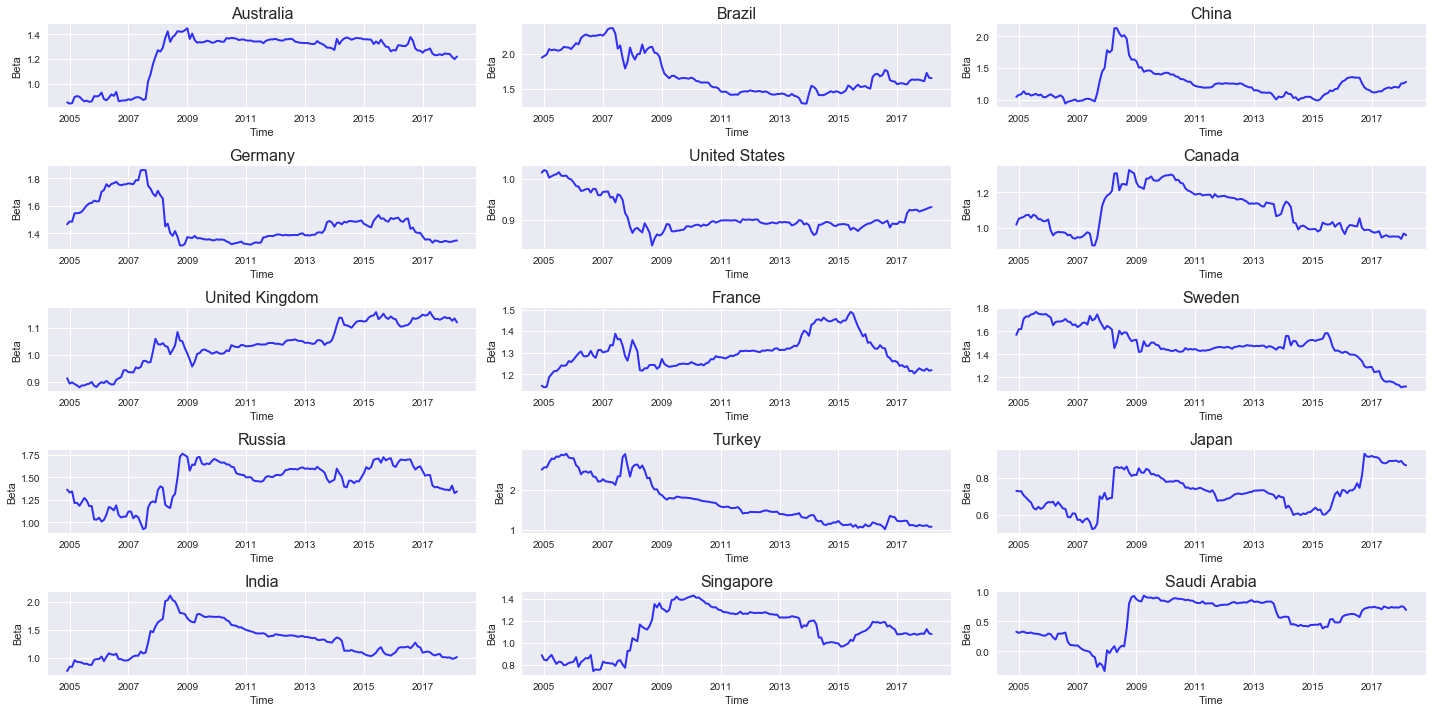

In [13]:
# Visualization of the beta coefficients development over time for each country

# Definition of a figure where to plot the graphs
fig = plt.figure(figsize=(20, 10))

# Initialisation of the loop to sequentially plot the beta development of each country equity index
for i in range(1, len(monthly_Eq_Ret.columns) + 1):

    # Definition of the first plot, in a matrix of graph of 5 rows and 3 columns
    ax = plt.subplot(5, 3, i)

    # Plotting the respective beta coefficients on the graph, defining the color, width, transparency and style of the
    # line
    betaSM_df.iloc[:, i-1].plot(ax=ax, color='blue', lw=2, alpha=0.8, ls='-')

    # Definition of the subplots name and fontsize
    ax.set_title(monthly_Eq_Ret.columns[i-1], fontsize=16)

    # Definition of the axes name
    ax.set(xlabel='Time', ylabel='Beta')

# Imposing a tight layout on a figure implies to ensure that texts are not overlapping in the graph
fig.tight_layout()

# Saving of the picture in the folder of the script under the file name and quality specified
fig.savefig('Beta_Development.png', dpi=150)

In [14]:
def betaTF(assetdf):
    """ This function uses the TensorFlow module. Given the returns of an asset/portfolio, the returns of the
    benchmark and the risk free rate time series, the function calculates the CAPM-Beta of the asset/portfolio
    given as input.
    The regression line estimated is:
    E[R_i]-rf = beta * E[R_m - rf] + alpha_i
    :return: beta coefficient of the regression model, hence the coefficient on the market excess returns
    """
    # Declaration of the initial guesses
    W = tf.Variable([1], dtype=tf.float64)
    b = tf.Variable([0], dtype=tf.float64)

    # Creation of placeholder nodes
    x = tf.placeholder(dtype=tf.float64)
    y = tf.placeholder(dtype=tf.float64)

    # Linear Model estimated
    linear_model = W * x + b

    # Total Loss, sum of all losses (Sum of differences between model outcome and actual obeserved y values)
    loss = tf.reduce_sum(tf.square(linear_model - y))

    # Optimizer, based on learning rate that allows to control the size of adjustment after each
    # step during the learning process
    optimizer = tf.train.MomentumOptimizer(0.001, 0.9)

    # Command that runs the training process to minimize the loss function
    train = optimizer.minimize(loss)

    # Data: actual observed x values (= E[R_m - rf])
    x_train = assetdf.iloc[:, 0] - assetdf.iloc[:, 2]
    # Inputs of actually observed values you want to achieve (so no part of the 'training'
    y_train = assetdf.iloc[:, 1] - assetdf.iloc[:, 2]

    # Command to create session
    session = tf.Session()

    # Initializer command, necessary when working with variable nodes
    init = tf.global_variables_initializer()
    tf.train.start_queue_runners(session)

    # Command to run the session
    session.run(init)

    # Loop to train, choose here 1000 times
    for i in range(1000):
        session.run(train, {x: x_train, y: y_train})

    # Run session on all three variables
    new_W, new_b, new_loss = session.run([W, b, loss], {x: x_train, y: y_train})
    return new_W

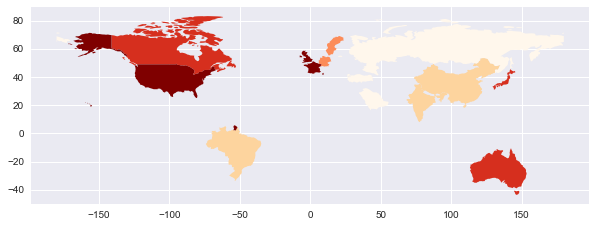

In [15]:
# Definition of a dataframe where we store the values of the beta coefficients retrieved using the Tensorflow module
betaTF_df = pd.DataFrame(index=monthly_Eq_Ret.columns, columns=['Tensorflow calculated Beta'])

# Initialisation of the loop cycle in order to estimate the CAPM beta of the equity indices with the Tensorflow module
for name in betaTF_df.index:

    # Definition of a temporary CAPM dataframe composed of three columns: the first column represents the equity index
    # returns of one country, the second the benchmark returns and finally the risk free rate
    CAPMtemp_df = pd.concat([monthly_Eq_Ret[name], MSCIWorld_Ret, monthly_rf_df], axis=1)

    # The values of the beta coefficients from the estimated CAPM model calculated with the Tensorflow module are
    # stored in the respective predefined dataframes, according to their country coordinates.
    betaTF_df.loc[name] = betaTF(CAPMtemp_df)

# Rearrange Pandas DataFrame and get dataset including geographic locations as GeoDataFrame
# Merge both data frames
betaTF_df['name'] = betaTF_df.index
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
betaTF_df_geo = world.merge(betaTF_df, on='name')

# Plot and save the world heat map in a figure
TF_beta = betaTF_df_geo.plot(column='Tensorflow calculated Beta', cmap='OrRd', scheme='quantiles', figsize= (10,5))
fig = TF_beta.get_figure()
fig.savefig('Heat Map of Regression Betas per Country')

### Linear Factor Models: Fama-French / Fama-MacBeth

In [16]:
def FamaFrenchRegr1(asset_ret, factors, rf_rate):
    """ First step of the Fama Macbeth approach: the function calculates the betas for each test asset, to be used
    in the second step of the Fama-MacBeth regression
    :param asset_ret: time series of the returns of one asset
    :param factors: DataFrame that includes the market returns and the 2 FF factors: SMB and HML
    :param rf_rate: time series of the risk free rate
    :return: Estimates of the betas for each factor, R squared of the regression and the predicted values of the
    asset returns
    """
    # Calculation of the asset excess returns: R_i - rf
    y_values = asset_ret.subtract(rf_rate, axis=0).dropna()

    # Calculation of the market excess returns: R_m - rf
    market_excess_ret = factors.iloc[:, 0].subtract(rf_rate, axis=0)

    # Creation of the factor data frame by concateniting the market excess returns with the Fama French factors:
    # SMB and HML
    FF3temp_df = pd.concat([market_excess_ret, factors.iloc[:, 1:]], axis=1)
    # Redefinition of the columns name of the Fama French Factors
    FF3temp_df.columns = ['Market Excess Returns', 'SMB', 'HML']

    # Adding a columns containing only 1 values, in order to estimate the intercept of a regression model
    x_values = sm.add_constant(FF3temp_df)

    # Estimating a regression model using the Fama French Factors as independent variables and the asset returns as
    # dependent variables, and storing its results in a variable
    model = sm.OLS(y_values, x_values).fit()

    # Returning the beta coefficients of the model, the R squared of the regression ans the predicted values of
    # the asset returns
    return model.params[1:], model.rsquared, model.predict(x_values)

In [17]:
def FamaFrenchRegr2(assets_ret, betas, rf_rate):
    """ Second step of the FMB regression: using the previously estimated beta, we try to estimate for each month the
    factors that determine the asset returns. All of this in order to test whether the factors are significant or not
    in determining the returns of our assets. As mentioned before, GRS Test is not possible since in a multifactor
    model the alphas of the regression are allowed to be different from zero, on the contrary of the CAPM model.
    :param assets_ret: Cross sectional array of returns. All returns of assets during 1 month
    :param betas: estimated betas from the First Step of the Fama MacBeth regression
    :param rf_rate: risk free rate value
    :return: market prices of risk for each factor. They are going to represent the estimated factor on time t
    """
    # Calculation of the excess returns of the assets during one single period of time
    y_values = assets_ret - rf_rate

    # Construction of the dataframe containing the independent variables values, which are the beta coefficients
    # estimated with the function FamaFrenchRegr1()
    x_values = pd.DataFrame(np.asarray(betas, dtype=np.float64), index=betas.index, columns=betas.columns)

    # Estimation of the regression model according to the specification of Fama and Macbeth of 1973
    model = sm.OLS(y_values, x_values).fit()

    # Returning of the coefficients of the regression
    return model.params

In [18]:
# Fama French Approach initialisation

# Definition of the dataframe containing the Fama French Factors, where the market excess returns have been replaced
# with the benchmark used in the CAPM, i.e. the MSCI World TR index returns
FF3Factors_df = pd.concat([MSCIWorld_Ret, FF3Factors], axis=1)

# Definition of the empty dataframes that are going to be filled later on
# Empty Dataframe that will contain the coefficient estimated with the Fama French Regression - step 1
FF3Coeff_df = pd.DataFrame(index=monthly_Eq_Ret.columns, columns=['Market Excess Returns', 'SMB', 'HML'])

# Empty Dataframe that will contain the predicted returns calculated with the Fama French Regression - step 1
FF3_Fitted_df = pd.DataFrame(index=monthly_Eq_Ret.index, columns=monthly_Eq_Ret.columns)

# Empty Dataframe that will contain the R squared coefficients of the Fama French Regression - step 1
FF3_r_squared = pd.DataFrame(index=monthly_Eq_Ret.columns, columns=['R Squared'])

# Empty Dataframe that will contain the residual value calculated with the Fama French Regression - step 2
FF3_resid_df = pd.DataFrame(index=monthly_Eq_Ret.index, columns=monthly_Eq_Ret.columns)

# Empty Dataframe that will contain the estimated factors values calculated with the Fama French Regression - step 2
FF3Factors_est_df = pd.DataFrame(index=FF3Factors_df.index, columns=FF3Coeff_df.columns)

In [26]:
# Initialisation of the loop that calculates the Fama French Coefficients, R squared and predicted values of the
# Fama French regression model. All values are stored in the respective dataframes. First step of the Fama MacBeth
# approach
for name in monthly_Eq_Ret.columns:

    # The outputs from the function FamaFrenchRegr1() are stored in the corresponding dataframes
    FF3Coeff_df.loc[name, :], FF3_r_squared.loc[name], FF3_Fitted_df[name] = FamaFrenchRegr1(monthly_Eq_Ret[name], FF3Factors_df, monthly_rf_df)

# Visualization of the Fama-French regression estimates
fig, ax = plt.subplots(figsize=(10, 10))
# Definition of the first sub-space of the figure
# hide axes
#fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
# Specification of the table, and of the table details
table = plt.table(cellText=np.asarray(FF3Coeff_df.values, dtype=np.float64).round(4),
                  colLabels=FF3Coeff_df.columns, rowLabels=FF3Coeff_df.index,
                  loc='center', colWidths=[0.2, 0.2, 0.2], colColours=['xkcd:green']*len(FF3Coeff_df.columns),
                  rowColours=['xkcd:khaki']*len(FF3Coeff_df.index))
# Making the table bigger
table.scale(1, 2.5)
# Setting the table title
ax.set_title('Fama French Coefficients values - Country Equity Indices Regression')
plt.tight_layout()
fig.savefig('Coefficients of the Fama French Regression.png')

In [27]:
# Initialisation of the loop that estimates the factor values using as independent variables the beta coefficients of
# estimated during the first step. The loops returns the estimates of the market prices of risk, and of the residuals
# from the Fama Macbeth regression. The first are the output of the function FamaFrenchRegr2, while the seconds are
# calculated in the loop.
for i in np.arange(0, len(monthly_Eq_Ret)):
    # The output from the function FamaFrenchRegr2() is stored in the corresponding dataframe
    FF3Factors_est_df.iloc[i, :] = FamaFrenchRegr2(monthly_Eq_Ret.iloc[i, :], FF3Coeff_df, monthly_rf_df[i])

    # temporal dataframe that observed contains the excess asset returns
    temp_excess_returns = monthly_Eq_Ret.iloc[i, :] - monthly_rf_df[i]

    # Temporal datataframe that contains the estimated excess market returns
    temp_fitted_excess_returns = np.matmul(np.asarray(FF3Coeff_df, dtype=np.float64), np.asarray(FF3Factors_est_df.iloc[i, :].T,
                                                                        dtype=np.float64))
    # Calculation of the residuals using the temporal dataframes built above
    FF3_resid_df.iloc[i, :] = temp_excess_returns - temp_fitted_excess_returns

# Calculation of the t-statistics of the market prices of risk and of the residuals from the FamaMacbeth regression
t_stat_factors = np.mean(FF3Factors_est_df)/np.std(FF3Factors_est_df)
t_stat_resid = np.mean(FF3_resid_df)/np.std(FF3_resid_df)

In [28]:
# Graphical visualization of the Fama French Approach results

# Definition of an empty figure
fig = plt.figure(figsize=(15, 21))

# Initialisation of the loop to sequentially visualize the scatter plots of the predicted and observed returns from the
# first step of the Fama MacBeth approach
for i in range(len(monthly_Eq_Ret.columns)):
    # Definition of the first plot, in a matrix of graph of 5 rows and 3 columns
    ax = plt.subplot(5, 3, i + 1)

    # Preparation of the string text to be printed on the graph: we want to print the value of the R squared for each
    # regression
    r_squared_str = str(round(float(FF3_r_squared.iloc[i])*100, 2)) + '%'

    # Scatter plot of the observed returns against the predicted ones. these results are from the first Fama French
    # regression
    ax.scatter(monthly_Eq_Ret.iloc[:, i], FF3_Fitted_df.iloc[:, i], alpha=0.5)

    # Definition of the graph details
    ax.plot([-1, 1], [-1, 1], color='black', lw=.5)
    ax.set_xlim((-0.5, 0.5))
    ax.set_ylim((-0.5, 0.5))
    ax.set_ylabel('Fama French Returns')
    ax.set_xlabel('Realized Returns')
    ax.set_title(monthly_Eq_Ret.columns[i])

    # Print on the graph the values of the R squared
    ax.text(-0.47, 0.4, 'R Squared = ' + r_squared_str)
fig.tight_layout()
fig.savefig('Fama French 3 Factors Regression Plots.png')

Fama French Building block completed successfully



Initialisation of the third building block: Portfolio Optimization





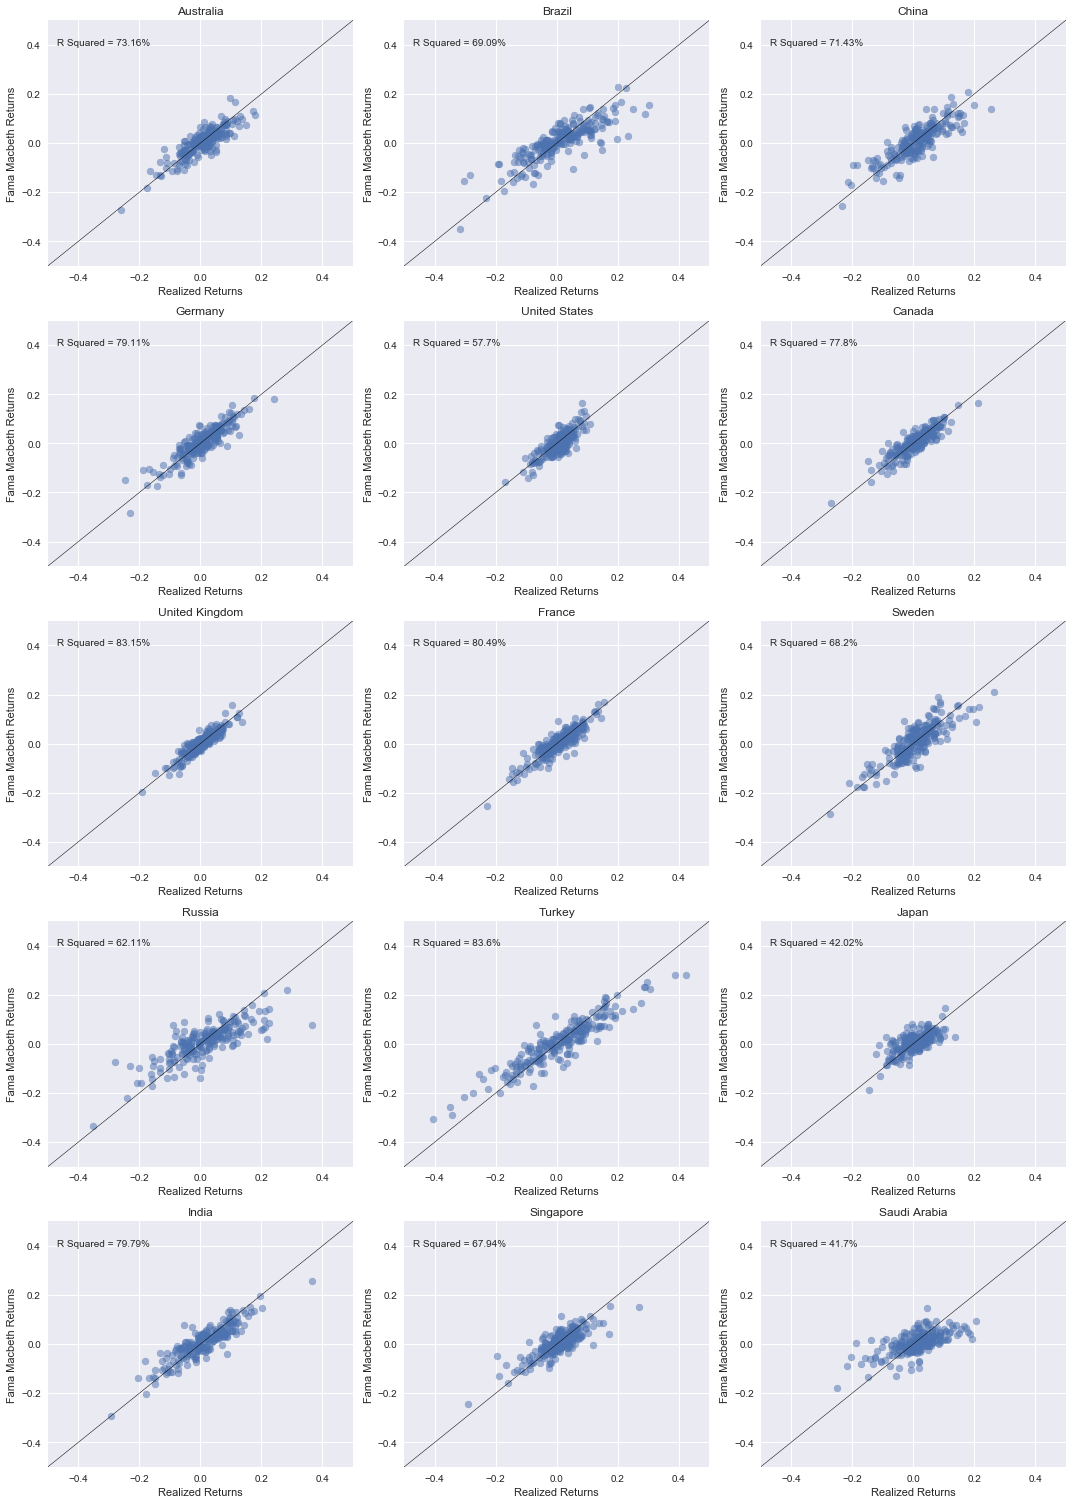

In [30]:
# Graphical visualization of the Fama Macbeth Approach results

# Definition of an empty figure
fig = plt.figure(figsize=(15, 21))

# Initialisation of the loop to sequentially visualize the scatter plots of the predicted and observed returns from the
# second step of the Fama MacBeth approach
for i in range(len(monthly_Eq_Ret.columns)):

    # Calculation of the fitted values deriving from the Fama Macbeth approach
    temp_FF3_predict = np.matmul(np.asarray(FF3Factors_est_df, dtype=np.float64), np.asarray(FF3Coeff_df.iloc[i, :], dtype=np.float64))

    # Definition of the first plot, in a matrix of graph of 5 rows and 3 columns
    ax = plt.subplot(5, 3, i + 1)

    # Calculation of the Sum of the Squared Errors
    sse = ((monthly_Eq_Ret.iloc[:, i] - temp_FF3_predict) ** 2).sum(axis=0)

    # Calculation of the Total Squared Errors
    tse = ((monthly_Eq_Ret.iloc[:, i] - np.average(monthly_Eq_Ret.iloc[:, i], axis=0)) ** 2).sum(axis=0)

    # Calculation of the R squared according to the formula 1 - (SSE/TSE)
    r_squared_score = 1 - (sse / tse)

    # Scatter plot of the observed returns against the predicted ones. these results are from the first Fama Macbeth
    # regression
    ax.scatter(monthly_Eq_Ret.iloc[:, i], np.matmul(np.asarray(FF3Factors_est_df, dtype=np.float64),
                                                    np.asarray(FF3Coeff_df.iloc[i, :], dtype=np.float64)), alpha=0.5)
    # Definition of the graph details
    ax.plot([-1, 1], [-1, 1], color='black', lw=.5)
    ax.set_xlim((-0.5, 0.5))
    ax.set_ylim((-0.5, 0.5))
    ax.set_ylabel('Fama Macbeth Returns')
    ax.set_xlabel('Realized Returns')
    ax.set_title(monthly_Eq_Ret.columns[i])

    # Print on the graph the value of the corresponding R squared of the regression
    ax.text(-0.47, 0.4, 'R Squared = ' + str(round(r_squared_score*100, 2)) + "%")
fig.tight_layout()
fig.savefig('FamaMacBeth Regression Plots.png')

print('Fama French Building block completed successfully\n\n\n')
print('Initialisation of the third building block: Portfolio Optimization\n\n\n')

### Portfolio Optimization

In [32]:
def annual_returns(returns):
    """ Given a monthly return, the function calculates the annualized return based on the following formula:
    R_ann = (1+R_mon)^12 -1
    :param returns: Monthly asset returns
    :return: Annualized asset returns
    """
    return (1+returns)**12 - 1

In [33]:
def cumulative_returns(asset_returns):
    """ Calculation of the cumulative returns of an asset, as if you invested 1$ one period prior the first asset return
    :param asset_returns: A dataframe containing asset returns (both series and dataframes)
    :return: cumulative returns of the series
    """
    # definition of the gross returns: 1+R_i,t
    gross_returns = 1 + asset_returns

    # Definition of an empty dataframe where the cumulative returns will be stored
    cumulative_returns = pd.DataFrame(columns=asset_returns.columns, index=asset_returns.index)

    # The first cumulative return is equal to the first gross return of the assets
    cumulative_returns.iloc[0, :] = gross_returns.iloc[0, :]

    # Loop that calculates the cumulative returns of a time series of gross returns
    for i in np.arange(1, len(asset_returns.index)):

        # At each incrementation of i, the corresponding cumulative return is equal to the product of all the
        # previous gross returns
        cumulative_returns.iloc[i, :] = gross_returns.iloc[i, :] * cumulative_returns.iloc[i-1, :]

    # Returning the cumulative returns time series/dataframe
    return cumulative_returns

In [34]:
def weights_sum(weights):
    """ This function returns the difference between the sum of the portfolio weights and 1. It is used for the
    maximization/minimization purposes
    :param weights: portfolio weights
    :return: 0 if the sum of the weights is 1
    """

    # it returns the difference between the sum of the weights and 1. The sum of the weights is calculated as the
    # Cartesian product of the row vector of the weights and the columns vector of ones
    return np.dot(weights.T, np.ones([len(weights), 1])) - 1

In [35]:
def optimal_portfolio(asset_returns, rf_rate, covMethod='empirical', *args, **kwargs):
    """ Given the assets as inputs, the function calculates the optimal weights, expected returns and variance of the
    optimal portfolio (the one with the maximum sharpe ratio) and of the minimum variance portfolio according to the
    settings specified by the user.
    :param asset_returns: a dataframe containing monthly asset returns
    :param rf_rate: the risk free rate time series
    :param covMethod: Specify the covariance method to use: 'empirical' (default) is empirical covariance, 'shrunk'
    employs the shrunk covariance as specified in Leidoit and Wolf, 2003; 'lasso' empoloys the Graphical Lasso
    covariance estimated as in Friedman, 2008
    :param args: expected returns, if one wants to override the expected returns to use in the optimization process.
    :param kwargs: Any kind of expected returns vector, which must comply with the dimension of the asset returns data
    frame
    :return: 2 objects: a dataframe that contains the weights of the efficient portfolio which obtains the maximum
    sharpe ratio, and the weights of the portfolio which obtains the minimum variance, given the assets received as
    input;a dataframe which contains the characteristics (variance and expected returns) of the above mentioned
    portfolios.
    """
    # We define the length of the time series of our asset returns. Useful later, to make sure that all the other
    # time series utilized have the same length
    asset_history = len(asset_returns)

    # We make sure that the time series of the risk free rate has the same length as the one of the asset returns
    rf_rate = rf_rate[-asset_history:]

    # Definition of the initial guesses array, representing the allocations of an equally weighted portfolio
    weights_0 = np.ones(len(asset_returns.columns)) / len(asset_returns.columns)

    # Second, define the constraints for the optimization function through a dictionare. The contraints is an equality
    # constraint, and it says that the sum of the weights cannot be different than 1, hence all available cash must be
    # allocated for the construction of the portfolio. Moreover, one cannot invest more than he owns, since the sum of
    # the weights cannot be greater than 1
    constraints = ({'type': 'eq', 'fun': weights_sum})

    # Here we define the bounds for each single element of the weights vector. If the lower bound is lower than 0,
    # we are allowing for the possibility to go short on some assets.
    bounds = ((0, 1),)*len(weights_0)

    # Here we define the excess asset returns as R_i - rf, udeful when maximizing the Sharpe Ratio of a portfolio
    excess_asset_returns = asset_returns.subtract(rf_rate, axis=0)

    # Define the annualized covariance matrix of our dataframe of monthly returns according to the methodology
    # specified in the inputs of the function
    if covMethod == 'shrunk':
        # We define a logarithmic space that ranges between 10^0 and 10^(-3) containing 100 datapoints
        shrinkages = np.logspace(-3, 0, 100)

        # Definition of a dictionary that associate the keyword 'shrinkage', to the logarithmic space defined above
        tuned_parameters = [{'shrinkage': shrinkages}]

        # Definition of the GridSearch object. It takes the object covariance.ShrunkCovariance and the dictionary
        # defined before as parameters
        best_alpha_search = GridSearchCV(covariance.ShrunkCovariance(), tuned_parameters)

        # We feed our GridSearch object with the annualized assets returns. The command will fit the ShrunkCovariance
        # object with the asset returns for all the values associated to the keyword 'shrinkage' of the dictionary
        # tuned_parameters, and find the shrinkage coefficient that yields the estimated covariance with the highest
        # loglikelihood
        best_alpha_search.fit(annual_returns(asset_returns))

        # We exctract the best alpha and store it in another variable
        alpha = best_alpha_search.best_estimator_.shrinkage

        # We create the object ShrunkCovariance where the value of the parameter shrinkage is the one that
        # maximizes the loglikelihood of the estimated covariance, found with the GridSeacrCV object
        model = covariance.ShrunkCovariance(shrinkage=alpha)

        # We feed our ShrunkCovaraince object with our annualized asset returns
        model.fit(annual_returns(asset_returns))

        # We extract the estimated annualized covariance matrix
        annual_covariance_matrix = model.covariance_

        # The same routine of before is repeated in order to estimate the annualized covariance matrix with the
        # excess asset returns. This estimated covariance will be used for the calculation of the maximum sharpe ratio
        # portfolio
        best_alpha_excess_search = GridSearchCV(covariance.ShrunkCovariance(), tuned_parameters)
        best_alpha_excess_search.fit(annual_returns(excess_asset_returns))
        alpha_excess = best_alpha_excess_search.best_estimator_.shrinkage

        model_excess = covariance.ShrunkCovariance(shrinkage=alpha_excess)
        model_excess.fit(annual_returns(excess_asset_returns))

        excess_annual_covariance_matrix = model_excess.covariance_

    elif covMethod == 'lasso':

        # We create a covariance.GraphLassoCV() object. Its function comprises the fine tuning of the hyper-parameters
        # for the estimation of a Graphical Lasso covariance, and the estimation of the covariance. Hence, it
        # compresses in one command the calculation of the shrinkage coefficient that maximizes the loglikelihood
        # of the covariance estimation, and the estimation of the covariance
        model = covariance.GraphLassoCV()

        # We fit the GraphLassoCV() object with the annualized asset returns
        model.fit(annual_returns(asset_returns))

        # We extract and store the estimated annualized covariance
        annual_covariance_matrix = model.covariance_

        # The same routine is executed for the asset excess returns, in order to estimate their annualized covariance
        # to be used for the calculation of the maximum sharpe ratio portfolio
        model_excess = covariance.GraphLassoCV()
        model_excess.fit(annual_returns(excess_asset_returns))

        # The annualized covariance is extracted and stored for later use
        excess_annual_covariance_matrix = model_excess.covariance_

    else:

        # Calculation of the empirical covariance, the most common estimator of the covariance. It estimates
        # the covariance of the annualized asset returns
        annual_covariance_matrix = covariance.empirical_covariance(annual_returns(asset_returns))

        # Calculation of the empirical covariance, the most common estimator of the covariance. It estimates
        # the covariance of the annualized excess asset returns
        excess_annual_covariance_matrix = covariance.empirical_covariance(annual_returns(excess_asset_returns))

    # Definition of the annualized expected returns according to the specifications given as input in the fucntion

    # If an additional input is given to the function, and the name of the input is: 'expected_returns',
    # this conditional code starts
    if len(kwargs) == 1:

        # When in the function, as additional input 'expected_returns=vector' is give, then we are specifying a
        # customized vector of asset expected returns to be used for the optimization problems. Therefore, we
        # are overriding the calculation of the expected returns, giving the function a manual input.
        # Here we extract the vector of expected returns given as input to the function. It is stored in a
        # dictionary kwargs under the keyword 'expected_returns'
        expected_annual_returns = annual_returns(kwargs.get('expected_returns', None))

    else:

        # If the expected returns are not override, they are calculated as mean of the asset returns
        expected_annual_returns = np.mean(annual_returns(asset_returns))

    # Definition of the annualized risk free rate to use in order to find the expected excess returns
    annual_rf_rate = np.mean(annual_returns(rf_rate))

    # Initialization of the optimizing function. It takes as function to minimize an anonymous function which
    # calculates the variance of a portfolio of assets. The independent variables, whose argmin we want to
    # calculate are the weights. The sum of the weights must be equal to zero, according to the constraints.
    # The values of the weights are bound between 0 and 1, according to the bounds parameter
    # We store the results of the minimization of the portfolio variance
    min_var_portfolio_results = \
        minimize(lambda weights: np.matmul(np.matmul(weights.T, annual_covariance_matrix), weights), weights_0,
                 method='SLSQP', bounds=bounds, constraints=constraints)

    # Storage of the weights that define the minimum variance portfolio
    min_var_weights = pd.DataFrame(min_var_portfolio_results.x, index=asset_returns.columns,
                                   columns=['Min Variance Weights'])

    # Calculation of the expected annual returns of the minimum variance portfolio
    min_var_portfolio_returns = np.dot(min_var_weights.T, expected_annual_returns)

    # Calculation of the variance of the minimum variance portfolio
    min_var_portfolio_variance = min_var_portfolio_results['fun']

    # Initialization of the optimizing function. It takes as function to minimize an anonymous function which
    # calculates the sharpe ratio of a portfolio of assets. The independent variables, whose argmin we want to
    # calculate are the weights. The sum of the weights must be equal to zero, according to the constraints.
    # The values of the weights are bound between 0 and 1, according to the bounds parameter
    # We store the results of the maximization of the sharpe ratio
    efficient_portfolio_results = \
        minimize(lambda weights: -(np.dot(weights.T, expected_annual_returns) - np.mean(annual_rf_rate)) /
                                 np.sqrt(np.matmul(np.matmul(weights.T, excess_annual_covariance_matrix), weights)),
                 weights_0, method='SLSQP', bounds=bounds, constraints=constraints)

    # Storage of the weights that define the maximum sharpe ratio portfolio
    efficient_weights = pd.DataFrame(efficient_portfolio_results.x, index=asset_returns.columns,
                                     columns=['Efficient Weights'])

    # Calculation of the expected annual returns of the maximum sharpe ratio portfolio
    efficient_portfolio_returns = np.dot(efficient_weights.T, expected_annual_returns)

    # Calculation of the variance of the maximum sharpe ratio portfolio
    efficient_portfolio_variance = \
        np.matmul(np.matmul(efficient_weights.T, annual_covariance_matrix), efficient_weights)

    # Compression of the weights of the maximum sharpe ratio and miminum variance portfolio in one datatframe
    weights_df = pd.concat([efficient_weights, min_var_weights], axis=1)

    # Compression of the risk-return profile of the minimum variance and maximum sharpe ratio portfolio in one dataframe
    optimal_portfolio = pd.DataFrame([[min_var_portfolio_returns, min_var_portfolio_variance],
                                      [efficient_portfolio_returns, efficient_portfolio_variance]],
                                     index=['Min Variance Portfolio', 'Efficient Portfolio'],
                                     columns=['Expected Returns', 'Variance'])
    # Returning the two compressed dataframes as output of the function
    return weights_df, optimal_portfolio

In [36]:
def efficient_frontier(asset_returns, min_var_portfolio_return, max_return, n_iter, covMethod='empirical'):
    """ The fucntion calculates the coordinates to obtain the graph of the Mean-Variance frontier, as defined
    in Markowitz 1952
    :param asset_returns: monthly Asset returns
    :param min_var_portfolio_return: return of the minimum variance portfolio, given the asset dataframe used as input
    :param max_return: maximum return that we would like to achieve using the time series of assets given as input
    :param n_iter: number of possible returns to explore.
    :param covMethod: Specify the covariance method to use: 'empirical' (default) is empirical covariance, 'shrunk'
    employs the shrunk covariance as specified in Leidoit and Wolf, 2003; 'lasso' empoloys the Graphical Lasso
    covariance estimated as in Friedman, 2008
    :return: Two dataframes: 1) a dataframe that contains variance and returns coordinates in order to plot the
    efficient frontier, as a result of the assets given as inputs; 2) returns and weights coordinates to explore how
    the portfolio weights vary according to the target returns that an investor would like to achieve
    """

    # Definition of the linear space containing the target returns of the Mean-Variance frontier
    frontier_returns = np.linspace(min_var_portfolio_return, max_return, n_iter)

    # Definition of an empty list that will contain the values of the variance of the optimal portfolios formed
    # in order to achieve the target returns
    frontier_var = []

    # Definition of an empty dataframe, where to store the weights used to achieve the target returns
    frontier_weights = pd.DataFrame(columns=asset_returns.columns, index=frontier_returns)

    # Calculation of the Expected annual returns of the assets given as input, calculated using the sample mean
    expected_annual_asset_returns = np.mean(annual_returns(asset_returns))

    # Define the annualized covariance matrix of our dataframe of monthly returns according to the methodology
    # specified in the inputs of the function
    if covMethod == 'shrunk':

        # We define a logarithmic space that ranges between 10^0 and 10^(-3) containing 100 datapoints
        shrinkages = np.logspace(-3, 0, 100)

        # Definition of a dictionary that associate the keyword 'shrinkage', to the logarithmic space defined above
        tuned_parameters = [{'shrinkage': shrinkages}]

        # Definition of the GridSearch object. It takes the object covariance.ShrunkCovariance and the dictionary
        # defined before as parameters
        best_alpha_search = GridSearchCV(covariance.ShrunkCovariance(), tuned_parameters)

        # We feed our GridSearch object with the annualized assets returns. The command will fit the ShrunkCovariance
        # object with the asset returns for all the values associated to the keyword 'shrinkage' of the dictionary
        # tuned_parameters, and find the shrinkage coefficient that yields the estimated covariance with the highest
        # loglikelihood
        best_alpha_search.fit(annual_returns(asset_returns))

        # We exctract the best alpha and store it in another variable
        alpha = best_alpha_search.best_estimator_.shrinkage

        # We create the object ShrunkCovariance where the value of the parameter shrinkage is the one that
        # maximizes the loglikelihood of the estimated covariance, found with the GridSeacrCV object
        model = covariance.ShrunkCovariance(shrinkage=alpha)

        # We feed our ShrunkCovaraince object with our annualized asset returns
        model.fit(annual_returns(asset_returns))

        # We exctract the estimated annualized covariance matrix
        annual_covariance = model.covariance_

    elif covMethod == 'lasso':

        # We create a covariance.GraphLassoCV() object. Its function comprises the fine tuning of the hyper-parameters
        # for the estimation of a Graphical Lasso covariance, and the estimation of the covariance. Hence, it
        # compresses in one command the calculation of the shrinkage coefficient that maximizes the loglikelihood
        # of the covariance estimation, and the estimation of the covariance
        model = covariance.GraphLassoCV()

        # We fit the GraphLassoCV() object with the annualized asset returns
        model.fit(annual_returns(asset_returns))

        # We extract and store the estimated annualized covariance
        annual_covariance = model.covariance_

    else:

        # Calculation of the empirical covariance, the most common estimator of the covariance. It estimates
        # the covariance of the annualized asset returns
        annual_covariance = covariance.empirical_covariance(annual_returns(asset_returns))

    # Definition of an indicator variable which will increment on 1 unit at the end of each loop, defined later
    i = 0

    # Setting the bounds of the weights for the optimization process, the investor cannot shortsell the assets, since
    # the lower bound is 0
    bounds = ((0, 1),)*len(asset_returns.columns)

    # Start of the loop that will calculate the coordinates of the Mean-Variance Frontier. Each point of the
    # Mean-Variance frontier represent a portfolio, whose allocation minimizes its variance, given the target return
    for target_return in frontier_returns:
        # Definition of the initial guesses array, representing the allocations of an equally weighted portfolio
        weights_0 = np.ones([len(asset_returns.columns), 1]) / len(asset_returns.columns)

        # Definition of the constraints for the optimization function through a dictionare. The contraints are two
        # equality constraints: and the sum of the weights cannot be different than 1, hence all available cash must be
        # allocated for the construction of the portfolio; the expected returns of the portfolio must be equal to the
        # target return due at each loop cycle
        constraints_frontier = ({'type': 'eq', 'fun': weights_sum},
                                {'type': 'eq',
                                 'fun': lambda w: np.dot(w.T, expected_annual_asset_returns)-target_return})

        # Initialization of the optimizing function. It takes as function to minimize an anonymous function which
        # calculates the variance of a portfolio of assets. The independent variables, whose argmin we want to
        # calculate, are the weights. The sum of the weights must be equal to 1 and the expected return of the portfolio
        # that the weights compose must be equal to the target return due on the cycle, according to the constraints.
        # The values of the weights are bound between 0 and 1, according to the bounds parameter.
        # We store the results of the minimization of the portfolio variance
        results = minimize(lambda weights: np.matmul(np.matmul(weights.T, annual_covariance), weights),
                           weights_0, method='SLSQP', bounds=bounds, constraints=constraints_frontier)

        # We store the minimum value of the variance of the portfolio calculated in the optimization in the list
        # frontier_var, through its attribute .append, which takes the value given as input and stores it as the last
        # value of the list
        frontier_var.append(results['fun'])

        # we store the row vector contianing the optimal weights calculated with the optimization function in the
        # frontier_weights dataframe defined at the beginning of the function, such that the target returns are the
        # index of our dataframe
        frontier_weights.iloc[i, :] = results.x

        # The indicator variable increments of 1
        i = i + 1

    # We define a dataframe containing the variance of the optimal portfolios, in order to prepare an ordinated
    # output for the function
    frontier_var_df = pd.DataFrame(frontier_var, columns=['Variance'])

    # We define a dataframe containing the target returns of the optimal portfolios, in order to prepare an ordinated
    # output for the function
    frontier_ret_df = pd.DataFrame(frontier_returns, columns=['Expected Return'])

    # We concatenate the two previously formed dataframe in one, in order to return it as a unique variable
    frontier_plot_data = pd.concat([frontier_var_df, frontier_ret_df], axis=1)

    # The function returns the coordinates of the mean variance frontier, and the frontier weights for each
    # target return.
    return frontier_plot_data, frontier_weights

In [37]:
def weight_df_builder(weight_df):
    """ The function returns a new weights dataframe where the values lower than 0.01 for each columns are substituted
    with 0, and aggregated in an additional column called "Other"
    :param weight_df: dataframe containing portfolio allocation weights
    :return: a new dataframes where weights < 0.01 are added together and stored in the column Others
    """
    # Definition of an empty dataframe, where the cleaned values of the weights are going to be stored
    new_weight_df = pd.DataFrame(index=weight_df.index, columns=weight_df.columns)

    # Start of the loop cycle which, for each row of the dataframe, selects the weights values lower than 0.1,
    # substitutes them with zero and aggregate them in a column caller Other
    for returns in weight_df.index:

        # A temporary dataframe is filled with the values weakly smaller than 0.01, belonging to the dataframe given as
        # input
        temp_zero_weight = weight_df.loc[returns, :][weight_df.loc[returns, :] <= 0.01]

        # A temporary dataframe is filled with the values greater than 0.01, belonging to the dataframe given as
        # input
        temp_non_zero_weight = weight_df.loc[returns, :][weight_df.loc[returns, :] > 0.01]

        # The column Other of the new weight dataframe is filled with the sum of the weights contained in the
        # temporary variable temp_zero_weight
        new_weight_df.loc[returns, 'Other'] = np.sum(temp_zero_weight)

        # This condition is useful when a value of the column other is an array [0] and not a float. In that case, the
        # column cannot be used in a plot. We prevent this from happening by setting the value 0 every time that the
        # columns other contains a boolean zero, which can be a number 0 or an array [0]
        if new_weight_df.loc[returns, 'Other'] == False:
            new_weight_df.loc[returns, 'Other'] = 0

        # When a row of a dataframe does not need to be adjusted, this condition is enabled, and it prevents the same
        # mistake that was happening before, i.e. it prevents that a array [0] is inserted in the dataframe
        if temp_zero_weight.shape == (1,):
            new_weight_df.loc[returns, temp_zero_weight.index] = 0
        else:

            # Whenever in a dataframe row there was a value lower than 0.01, in the new dataframe will be written 0
            new_weight_df.loc[returns, temp_zero_weight.index] = np.zeros((len(temp_zero_weight.index),))

        # The remaining columns of the new weight dataframe are populated with the values greater than 0.01 stored in
        # the temp_non_zero_weight variable
        new_weight_df.loc[returns, temp_non_zero_weight.index] = temp_non_zero_weight

    # The aggregated weight dataframe is returned as output of the function
    return new_weight_df

In [38]:
# Initialization of the second building block of the project: Optimization of the portfolio asset allocation

# Optimization of the portfolio made of Country Equity Indices

# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios - Country Equity Indices
optimal_equity_weights, optimal_equity_portfolio = optimal_portfolio(monthly_Eq_Ret, monthly_rf_df)

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights - Country Equity Indices
optimal_equity_frontier_data, optimal_equity_frontier_weights_df = efficient_frontier(monthly_Eq_Ret, optimal_equity_portfolio.iloc[0, 0], 1, 150)

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Country Equity Indices
optimal_equity_portfolio_returns = pd.DataFrame(np.matmul(monthly_Eq_Ret, optimal_equity_weights['Efficient Weights']),
                                                index=monthly_Eq_Ret.index, columns=['Equity Portfolio Returns'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Country Equity Indices
optimal_equity_cum_return = cumulative_returns(optimal_equity_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Country Equity Indices
min_var_equity_portfolio_returns = pd.DataFrame(np.matmul(monthly_Eq_Ret, optimal_equity_weights['Min Variance Weights']), index=monthly_Eq_Ret.index,
                                                columns=['Equity Portfolio Returns'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Country Equity Indices
min_var_equity_cum_return = cumulative_returns(min_var_equity_portfolio_returns)

# Visualisation of the max sharpe ratio and minimum variance portfolios and of the weight composition of the Mean
# Variance Frontier across the target returns

# Aggregation of the weigths dataframes using the function weight_df_builder(), in order to aggregate in one column
# the country weights lower than 0.01. This is done for both the minimum variance and the maximum sharpe ratio
# portfolio. In addition, the same function is applied to the weights dataframe of the Mean variance Frontier
compact_optimal_equity_weight = weight_df_builder(optimal_equity_weights.T)
compact_optimal_equity_frontier_weights_df = weight_df_builder(optimal_equity_frontier_weights_df)

# We change the palette of color of the graph, such that the contrast between two neighbour color is maximized
with seaborn.color_palette(palette='Paired', n_colors=15):

    # We create a empty figure and divide since the beginning the space in a column vector of empty graphs made of
    # three rows
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))

    # Designing a pie chart whose labels are the columns of the weights dataframe, and the values are expressed in
    # percentage points - first graph
    compact_optimal_equity_weight.iloc[0, :][compact_optimal_equity_weight.iloc[0, :] > 0].plot(ax=ax[0], kind='pie', autopct='%1.1f%%')

    # Setting the graph details - first graph
    ax[0].set_title('Max Sharpe Ratio Weights\nEquity Portfolio')
    ax[0].set_ylabel('')
    ax[0].axis('equal')

    # Designing a pie chart whose labels are the columns of the weights dataframe, and the values are expressed in
    # percentage points - second graph
    compact_optimal_equity_weight.iloc[1, :][compact_optimal_equity_weight.iloc[1, :] > 0].plot(ax=ax[1], kind='pie', autopct='%1.1f%%')

    # Setting the graph details - second graph
    ax[1].set_title('Min Variance Weights\nEquity Portfolio')
    ax[1].axis('equal')
    ax[1].set_ylabel('')

    # Setting the area plot that shows the development of the portfolio allocation depending on the target return to
    # achieve
    compact_optimal_equity_frontier_weights_df.plot(ax=ax[2], kind='area', lw=0, alpha=0.8)

    # Setting the graph details - third graph
    ax[2].set_title('Frontier Weights across Equity Returns')
    ax[2].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
              xlim=[min(compact_optimal_equity_frontier_weights_df.index),
                    max(compact_optimal_equity_frontier_weights_df.index)])

    # Move the legend of the third graph, so that it does not overlap with the plot
    ax[2].legend(loc='upper left', prop={'size': 8}, bbox_to_anchor=(1, 1))

    # reducing the width of the subplots, so that the legend of the third graph is not cut out
    plt.subplots_adjust(right=0.75)
fig.savefig('Equity Optimization - Weights visualization.png')

In [39]:
# We now optimize the portfolio made of sovereign bond indices

# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios - Sovereign Bond Indices
optimal_bond_weights, optimal_bond_portfolio = optimal_portfolio(monthly_bond_ret, monthly_rf_df)

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights - Sovereign Bond Indices
optimal_bond_frontier_data, optimal_bond_frontier_weights_df = \
    efficient_frontier(monthly_bond_ret, optimal_bond_portfolio.iloc[0, 0], 0.255, 150)

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Sovereign Bond Indices
optimal_bond_portfolio_returns = pd.DataFrame(np.matmul(monthly_bond_ret, optimal_bond_weights['Efficient Weights']),
                                              index=monthly_bond_ret.index, columns=['Bond Portfolio Returns'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Sovereign Bond Indices
optimal_bond_cum_return = cumulative_returns(optimal_bond_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Sovereign Bond Indices
min_var_bond_portfolio_returns = pd.DataFrame(np.matmul(monthly_bond_ret, optimal_bond_weights['Min Variance Weights']),
                                              index=monthly_bond_ret.index, columns=['Bond Portfolio Returns'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Sovereign Bond Indices
min_var_bond_cum_return = cumulative_returns(min_var_bond_portfolio_returns)

In [40]:
# Setting up the 60-40 Equity Bond Portfolio and introduction of Hedge Funds Indices as Portfolio Assets

# Concatenation of the time series returns of the maximum sharpe ratio equity and bond portfolios
optimal_equity_bond_portfolio_ret = \
    pd.DataFrame(pd.concat([optimal_equity_portfolio_returns, optimal_bond_portfolio_returns], axis=1).dropna(),
                 index=optimal_bond_portfolio_returns.index,
                 columns=['Equity Portfolio Returns', 'Bond Portfolio Returns'])

# Calculation of the returns of a portfolio made of 60% of the maxiumum sharpe ratio portfolio of equity indices, and
# of 40% of maximum sharpe ratio portfolio of sovereign bond indices
sixty_forty_equity_bond_ret = \
    pd.DataFrame(np.matmul(optimal_equity_bond_portfolio_ret, np.array([0.6, 0.4]).T),
                 index=optimal_equity_bond_portfolio_ret.index, columns=['60/40 Portfolio Returns'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the 60-40 equity-bond
# portfolio
sixty_forty_equity_bond_cum_ret = cumulative_returns(sixty_forty_equity_bond_ret)

# Concatenation of the time series returns of the 60-40 equity-bond portfolio and the hedge fund returns
sixty_forty_hf_portfolio_ret = pd.DataFrame(pd.concat([sixty_forty_equity_bond_ret, hf_indices],
                                                      axis=1).dropna(), index=sixty_forty_equity_bond_ret.index)

# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios - Hedge funds Indices and 60-40 equity-bond portfolios
optimal_sixty_forty_hf_weights, optimal_sixty_forty_hf_portfolio = \
    optimal_portfolio(sixty_forty_hf_portfolio_ret, monthly_rf_df)

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights - Hedge funds Indices and 60-40 equity-bond portfolios
optimal_sixty_forty_hf_frontier_data, optimal_sixty_forty_hf_frontier_weights_df = \
    efficient_frontier(sixty_forty_hf_portfolio_ret, optimal_sixty_forty_hf_portfolio.iloc[0, 0], 0.22, 150)

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Hedge funds Indices and
# 60-40 equity-bond portfolios
optimal_sixty_forty_hf_portfolio_returns = \
    pd.DataFrame(np.matmul(sixty_forty_hf_portfolio_ret, optimal_sixty_forty_hf_weights['Efficient Weights']),
                 index=sixty_forty_hf_portfolio_ret.index, columns=['Bond/Equity/HF Portfolio Returns'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Hedge funds Indices and 60-40 equity-bond portfolios
optimal_sixty_forty_hf_cum_return = cumulative_returns(optimal_sixty_forty_hf_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Hedge funds Indices and
# 60-40 equity-bond portfolios
min_var_sixty_forty_hf_portfolio_returns = \
    pd.DataFrame(np.matmul(sixty_forty_hf_portfolio_ret, optimal_sixty_forty_hf_weights['Min Variance Weights']),
                 index=sixty_forty_hf_portfolio_ret.index, columns=['Bond/Equity/HF Portfolio Returns'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Hedge funds Indices and 60-40 equity-bond portfolios
min_var_sixty_forty_hf_cum_return = cumulative_returns(min_var_sixty_forty_hf_portfolio_returns)

### Machine Learning Approach to Portfolio optimization

In [41]:
# Start Of the Machine Learning approach

# Country Equity Portfolio Approach
# Shrunk Covariance Approach

# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios using the Shrunk covariance method in order to see if we can
# improve the risk-return profile of our portfolio by employing a different measure of the covariance - Country Equity
# Indices
optimal_shrunk_equity_weights, optimal_shrunk_equity_portfolio = optimal_portfolio(monthly_Eq_Ret, monthly_rf_df, covMethod='shrunk')

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights using the Shrunk covariance method in order to see if the portfolio allocations across the
# target returns improves, in terms of diversification, by employing a different measure of the covariance - Country
# Equity Indices
optimal_shrunk_equity_frontier_data, optimal_shrunk_equity_frontier_weights_df = efficient_frontier(monthly_Eq_Ret, optimal_shrunk_equity_portfolio.iloc[0, 0], 1.3, 150, covMethod='shrunk')

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Country Equity Indices
# using the Shrunk Covariance
optimal_shrunk_equity_portfolio_returns = pd.DataFrame(np.matmul(monthly_Eq_Ret, optimal_shrunk_equity_weights['Efficient Weights']),
                                                       index=monthly_Eq_Ret.index, columns=['Equity Portfolio Returns - Shrunk'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Country Equity Indices using the Shrunk Covariance
optimal_shrunk_equity_cum_return = cumulative_returns(optimal_shrunk_equity_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Country Equity Indices
# using the Shrunk Covariance
min_var_shrunk_equity_portfolio_returns = pd.DataFrame(np.matmul(monthly_Eq_Ret, optimal_shrunk_equity_weights['Min Variance Weights']), index=monthly_Eq_Ret.index, columns=['Equity Portfolio Returns - Shrunk'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Country Equity Indices using the Shrunk Covariance
min_var_shrunk_equity_cum_return = cumulative_returns(min_var_shrunk_equity_portfolio_returns)

In [42]:
# Graphical Lasso Covariance Approach

# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios using the Graphical Lasso covariance method in order to see if
# we can improve the risk-return profile of our portfolio by employing a different measure of the covariance - Country
# Equity Indices
optimal_lasso_equity_weights, optimal_lasso_equity_portfolio = \
    optimal_portfolio(monthly_Eq_Ret, monthly_rf_df, covMethod='lasso')

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights using the Graphical Lasso covariance method in order to see if the portfolio allocations
# across the target returns improves, in terms of diversification, by employing a different measure of the covariance -
# Country Equity Indices
optimal_lasso_equity_frontier_data, optimal_lasso_equity_frontier_weights_df = \
    efficient_frontier(monthly_Eq_Ret, optimal_lasso_equity_portfolio.iloc[0, 0], 1.3, 150, covMethod='lasso')

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Country Equity Indices
# using the Graphical Lasso Covariance
optimal_lasso_equity_portfolio_returns = \
    pd.DataFrame(np.matmul(monthly_Eq_Ret, optimal_lasso_equity_weights['Efficient Weights']),
                 index=monthly_Eq_Ret.index, columns=['Equity Portfolio Returns - Lasso'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Country Equity Indices using the Graphical Lasso Covariance
optimal_lasso_equity_cum_return = cumulative_returns(optimal_lasso_equity_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Country Equity Indices
# using the Graphical Lasso Covariance
min_var_lasso_equity_portfolio_returns = \
    pd.DataFrame(np.matmul(monthly_Eq_Ret, optimal_lasso_equity_weights['Min Variance Weights']),
                 index=monthly_Eq_Ret.index, columns=['Equity Portfolio Returns - Lasso'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Country Equity Indices using the Graphical Lasso Covariance
min_var_lasso_equity_cum_return = cumulative_returns(min_var_lasso_equity_portfolio_returns)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


In [43]:
# Sovereign Bond Portfolio Optimization

# Shrunk Covariance Approach

# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios using the Shrunk covariance method in order to see if
# we can improve the risk-return profile of our portfolio by employing a different measure of the covariance - Sovereign
# Bond Indices
optimal_shrunk_bond_weights, optimal_shrunk_bond_portfolio = \
    optimal_portfolio(monthly_bond_ret, monthly_rf_df, covMethod='shrunk')

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights using the Shrunk covariance method in order to see if the portfolio allocations
# across the target returns improves, in terms of diversification, by employing a different measure of the covariance -
# Sovereign Bond Indices
optimal_shrunk_bond_frontier_data, optimal_shrunk_bond_frontier_weights_df = \
    efficient_frontier(monthly_bond_ret, optimal_shrunk_bond_portfolio.iloc[0, 0], 0.255, 150, covMethod='shrunk')

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Sovereign Bond Indices
# using the Shrunk Covariance
optimal_shrunk_bond_portfolio_returns = \
    pd.DataFrame(np.matmul(monthly_bond_ret, optimal_shrunk_bond_weights['Efficient Weights']),
                 index=monthly_bond_ret.index, columns=['Bond Portfolio Returns - Shrunk'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Sovereign Bond Indices using the Shrunk Covariance
optimal_shrunk_bond_cum_return = cumulative_returns(optimal_shrunk_bond_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Sovereign Bond Indices
# using the Shrunk Covariance
min_var_shrunk_bond_portfolio_returns = \
    pd.DataFrame(np.matmul(monthly_bond_ret, optimal_shrunk_bond_weights['Min Variance Weights']),
                 index=monthly_bond_ret.index, columns=['Bond Portfolio Returns - Shrunk'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Sovereign Bond Indices using the Shrunk Covariance
min_var_shrunk_bond_cum_return = cumulative_returns(min_var_shrunk_bond_portfolio_returns)

# Graphical Lasso Covariance approach
# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios using the Graphical Lasso covariance method in order to see if
# we can improve the risk-return profile of our portfolio by employing a different measure of the covariance - Sovereign
# Bond Indices
optimal_lasso_bond_weights, optimal_lasso_bond_portfolio = \
    optimal_portfolio(monthly_bond_ret, monthly_rf_df, covMethod='lasso')

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights using the Graphical Lasso covariance method in order to see if the portfolio allocations
# across the target returns improves, in terms of diversification, by employing a different measure of the covariance -
# Sovereign Bond Indices
optimal_lasso_bond_frontier_data, optimal_lasso_bond_frontier_weights_df = \
    efficient_frontier(monthly_bond_ret, optimal_lasso_bond_portfolio.iloc[0, 0], 0.255, 150, covMethod='lasso')

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Sovereign Bond Indices
# using the Graphical Lasso Covariance
optimal_lasso_bond_portfolio_returns = \
    pd.DataFrame(np.matmul(monthly_bond_ret, optimal_lasso_bond_weights['Efficient Weights']),
                 index=monthly_bond_ret.index, columns=['Bond Portfolio Returns - Lasso'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Sovereign Bond Indices using the Graphical Lasso Covariance
optimal_lasso_bond_cum_return = cumulative_returns(optimal_lasso_bond_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Sovereign Bond Indices
# using the Graphical Lasso Covariance
min_var_lasso_bond_portfolio_returns = \
    pd.DataFrame(np.matmul(monthly_bond_ret, optimal_lasso_bond_weights['Min Variance Weights']),
                 index=monthly_bond_ret.index, columns=['Bond Portfolio Returns - Lasso'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Sovereign Bond Indices using the Graphical Lasso Covariance
min_var_lasso_bond_cum_return = cumulative_returns(min_var_lasso_bond_portfolio_returns)

In [44]:
# Hedge Fund Indices and 60-40 equity-bond portfolio Optimization

# Shrunk Covariance approach
# Concatenation of the time series returns of the maximum sharpe ratio equity and bond portfolios obtained using the
# Shrunk covariance estimation
optimal_shrunk_equity_bond_portfolio_ret = \
    pd.concat([optimal_shrunk_equity_portfolio_returns, optimal_shrunk_bond_portfolio_returns], axis=1).dropna()

# Redefinition of the columns name of the newly created dataframe, in order to distinguish it from the ones calculated
# using the empirical covariance and the Graphical Lasso covariance
optimal_shrunk_equity_bond_portfolio_ret.columns = \
    ['Equity Portfolio Returns - Shrunk', 'Bond Portfolio Returns - Shrunk']

# Calculation of the returns of a portfolio made of 60% of the maximum sharpe ratio portfolio of equity indices, and
# of 40% of maximum sharpe ratio portfolio of sovereign bond indices obtained using the Shrunk covariance estimation
shrunk_sixty_forty_equity_bond_ret = \
    pd.DataFrame(np.matmul(optimal_shrunk_equity_bond_portfolio_ret, np.array([0.6, 0.4]).T),
                 index=optimal_shrunk_equity_bond_portfolio_ret.index, columns=['60/40 Portfolio Returns - Shrunk'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the 60-40 equity-bond
# portfolio created using the Shrunk covariance estimation
shrunk_sixty_forty_equity_bond_cum_ret = cumulative_returns(shrunk_sixty_forty_equity_bond_ret)

# Concatenation of the time series returns of the 60-40 equity-bond portfolio obtained using the Shrunk covariance
# with the hedge fund returns
shrunk_sixty_forty_hf_portfolio_ret = \
    pd.DataFrame(pd.concat([shrunk_sixty_forty_equity_bond_ret, hf_indices], axis=1).dropna(),
                 index=shrunk_sixty_forty_equity_bond_ret.index)

# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios using the Shrunk covariance method in order to see if
# we can improve the risk-return profile of our portfolio by employing a different measure of the covariance - Hedge
# Fund Indices and 60-40 equity-bond portfolio
optimal_shrunk_sixty_forty_hf_weights, optimal_shrunk_sixty_forty_hf_portfolio = \
    optimal_portfolio(shrunk_sixty_forty_hf_portfolio_ret, monthly_rf_df, covMethod='shrunk')

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights using the Shrunk covariance method in order to see if the portfolio allocations
# across the target returns improves, in terms of diversification, by employing a different measure of the covariance -
# Hedge Fund Indices and 60-40 equity-bond portfolio
optimal_shrunk_sixty_forty_hf_frontier_data, optimal_shrunk_sixty_forty_hf_frontier_weights_df = \
    efficient_frontier(shrunk_sixty_forty_hf_portfolio_ret, optimal_shrunk_sixty_forty_hf_portfolio.iloc[0, 0],
                       0.22, 150, covMethod='shrunk')

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Hedge Fund Indices and
# 60-40 equity-bond portfolio using the Shrunk Covariance
optimal_shrunk_sixty_forty_hf_portfolio_returns = \
    pd.DataFrame(np.matmul(shrunk_sixty_forty_hf_portfolio_ret,
                           optimal_shrunk_sixty_forty_hf_weights['Efficient Weights']),
                 index=shrunk_sixty_forty_hf_portfolio_ret.index, columns=['Bond/Equity/HF Portfolio Returns - Shrunk'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Hedge Fund Indices and 60-40 equity-bond portfolio using the Shrunk Covariance
optimal_shrunk_sixty_forty_hf_cum_return = cumulative_returns(optimal_shrunk_sixty_forty_hf_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Hedge Fund Indices and
# 60-40 equity-bond portfolio using the Shrunk Covariance
min_var_shrunk_sixty_forty_hf_portfolio_returns = \
    pd.DataFrame(np.matmul(shrunk_sixty_forty_hf_portfolio_ret,
                           optimal_shrunk_sixty_forty_hf_weights['Min Variance Weights']),
                 index=shrunk_sixty_forty_hf_portfolio_ret.index, columns=['Bond/Equity/HF Portfolio Returns - Shrunk'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Hedge Fund Indices and 60-40 equity-bond portfolio using the Shrunk Covariance
min_var_shrunk_sixty_forty_hf_cum_return = cumulative_returns(min_var_shrunk_sixty_forty_hf_portfolio_returns)

# Graphical Lasso Covariance approach
# Concatenation of the time series returns of the maximum sharpe ratio equity and bond portfolios obtained using the
# Graphical Lasso covariance estimation
optimal_lasso_equity_bond_portfolio_ret = \
    pd.concat([optimal_lasso_equity_portfolio_returns, optimal_lasso_bond_portfolio_returns], axis=1).dropna()

# Redefinition of the columns name of the newly created dataframe, in order to distinguish it from the ones calculated
# using the empirical covariance and the Shrunk covariance
optimal_lasso_equity_bond_portfolio_ret.columns = ['Equity Portfolio Returns - Lasso', 'Bond Portfolio Returns - Lasso']

# Calculation of the returns of a portfolio made of 60% of the maximum sharpe ratio portfolio of equity indices, and
# of 40% of maximum sharpe ratio portfolio of sovereign bond indices obtained using the Graphical Lasso covariance
# estimation
lasso_sixty_forty_equity_bond_ret = \
    pd.DataFrame(np.matmul(optimal_lasso_equity_bond_portfolio_ret, np.array([0.6, 0.4]).T),
                 index=optimal_lasso_equity_bond_portfolio_ret.index, columns=['60/40 Portfolio Returns - Lasso'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the 60-40 equity-bond
# portfolio created using the Graphical Lasso covariance estimation
lasso_sixty_forty_equity_bond_cum_ret = cumulative_returns(lasso_sixty_forty_equity_bond_ret)

# Concatenation of the time series returns of the 60-40 equity-bond portfolio obtained using the Graphical Lasso
# covariance with the hedge fund returns
lasso_sixty_forty_hf_portfolio_ret = \
    pd.DataFrame(pd.concat([lasso_sixty_forty_equity_bond_ret, hf_indices], axis=1).dropna(),
                 index=lasso_sixty_forty_equity_bond_ret.index)

# Using the optimal_portfolio() function we store the values of the weigths and the portfolio characteristics of the
# Minimum Variance and Maximum Sharpe ratios portfolios using the Graphical Lasso covariance method in order to see if
# we can improve the risk-return profile of our portfolio by employing a different measure of the covariance - Hedge
# Fund Indices and 60-40 equity-bond portfolio
optimal_lasso_sixty_forty_hf_weights, optimal_lasso_sixty_forty_hf_portfolio = \
    optimal_portfolio(lasso_sixty_forty_hf_portfolio_ret, monthly_rf_df, covMethod='lasso')

# Using the efficient_frontier() function we store the coordinates of the efficient frontier, and the corresponding
# optimal portfolio weights using the Graphical Lasso covariance method in order to see if the portfolio allocations
# across the target returns improves, in terms of diversification, by employing a different measure of the covariance -
# Hedge Fund Indices and 60-40 equity-bond portfolio
optimal_lasso_sixty_forty_hf_frontier_data, optimal_lasso_sixty_forty_hf_frontier_weights_df = \
    efficient_frontier(lasso_sixty_forty_hf_portfolio_ret, optimal_lasso_sixty_forty_hf_portfolio.iloc[0, 0],
                       0.165, 150, covMethod='lasso')

# We now calculate the portfolio returns time series of the maximum sharpe ratio portfolio - Hedge Fund Indices and
# 60-40 equity-bond portfolio using the Graphical Lasso Covariance
optimal_lasso_sixty_forty_hf_portfolio_returns = \
    pd.DataFrame(np.matmul(lasso_sixty_forty_hf_portfolio_ret,
                           optimal_lasso_sixty_forty_hf_weights['Efficient Weights']),
                 index=lasso_sixty_forty_hf_portfolio_ret.index, columns=['Bond/Equity/HF Portfolio Returns - Lasso'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the maximum sharpe ratio
# portfolio - Hedge Fund Indices and 60-40 equity-bond portfolio using the Graphical Lasso Covariance
optimal_lasso_sixty_forty_hf_cum_return = cumulative_returns(optimal_lasso_sixty_forty_hf_portfolio_returns)

# We now calculate the portfolio returns time series of the minimum variance portfolio - Hedge Fund Indices and
# 60-40 equity-bond portfolio using the Graphical Lasso Covariance
min_var_lasso_sixty_forty_hf_portfolio_returns = \
    pd.DataFrame(np.matmul(lasso_sixty_forty_hf_portfolio_ret,
                           optimal_lasso_sixty_forty_hf_weights['Min Variance Weights']),
                 index=lasso_sixty_forty_hf_portfolio_ret.index, columns=['Bond/Equity/HF Portfolio Returns - Lasso'])

# With the function cumulative_returns(), we calculate the cumulative returns time series of the minimum variance
# portfolio - Hedge Fund Indices and 60-40 equity-bond portfolio using the Graphical Lasso Covariance
min_var_lasso_sixty_forty_hf_cum_return = cumulative_returns(min_var_lasso_sixty_forty_hf_portfolio_returns)

# Graphical visualization of the cumulative portfolio returns for the portfolios created above
# Here we concatenate in dataframes the cumulative returns on the maximum sharpe ratio portfolios formed using the three
# different covariance methods
optimal_equity_portfolio_cum_ret_comp = \
    pd.concat([optimal_equity_cum_return, optimal_shrunk_equity_cum_return, optimal_lasso_equity_cum_return], axis=1)

optimal_bond_portfolio_cum_ret_comp = \
    pd.concat([optimal_bond_cum_return, optimal_shrunk_bond_cum_return, optimal_lasso_bond_cum_return], axis=1)

optimal_sixty_forty_hf_portfolio_cum_ret_comp = \
    pd.concat([optimal_sixty_forty_hf_cum_return, optimal_shrunk_sixty_forty_hf_cum_return,
               optimal_lasso_sixty_forty_hf_cum_return], axis=1)

# Here we concatenate in dataframes the cumulative returns on the minimum variance portfolios formed using the three
# different covariance methods
min_var_equity_portfolio_cum_ret_comp = \
    pd.concat([min_var_equity_cum_return, min_var_shrunk_equity_cum_return, min_var_lasso_equity_cum_return], axis=1)

min_var_bond_portfolio_cum_ret_comp = \
    pd.concat([min_var_bond_cum_return, min_var_shrunk_bond_cum_return, min_var_lasso_bond_cum_return], axis=1)

min_var_sixty_forty_hf_portfolio_cum_ret_comp = \
    pd.concat([min_var_sixty_forty_hf_cum_return, min_var_shrunk_sixty_forty_hf_cum_return,
               min_var_lasso_sixty_forty_hf_cum_return], axis=1)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


In [45]:
# Graphical Visualisation of the cumulative returns contained in the previously concatenated dataframes

# We create a empty figure and divide starting from the beginning the space in a matrix of empty graphs made of
# three rows and two columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 15))

# Plotting of the cumulative returns of the Country Equity indices maximum sharpe ratio portfolios formed using
# different methods for estimating the covariance
optimal_equity_portfolio_cum_ret_comp.plot(ax=axes[0, 0], lw=2, alpha=0.8, ls='-')

# Defining the graph details
axes[0, 0].set_title('Max Sharpe Ratio Portfolio Returns', fontsize=16)
axes[0, 0].set(xlabel='Time', ylabel='Cumulative Monthly Returns')

# Plotting of the cumulative returns of the Country Equity indices minimum variance portfolios formed using
# different methods for estimating the covariance
min_var_equity_portfolio_cum_ret_comp.plot(ax=axes[0, 1], lw=2, alpha=0.8, ls='-')

# Defining the graph details
axes[0, 1].set_title('Min Variance Portfolio Returns', fontsize=16)
axes[0, 1].set(xlabel='Time', ylabel='Cumulative Monthly Returns')

# Plotting of the cumulative returns of the Sovereign Bond indices maximum sharpe ratio portfolios formed using
# different methods for estimating the covariance
optimal_bond_portfolio_cum_ret_comp.plot(ax=axes[1, 0], lw=2, alpha=0.8, ls='-')

# Defining the graph details
axes[1, 0].set_title('Max Sharpe Ratio Portfolio Returns', fontsize=16)
axes[1, 0].set(xlabel='Time', ylabel='Cumulative Monthly Returns')

# Plotting of the cumulative returns of the Sovereign Bond indices minimum variance portfolios formed using
# different methods for estimating the covariance
min_var_bond_portfolio_cum_ret_comp.plot(ax=axes[1, 1], lw=2, alpha=0.8, ls='-')

# Defining the graph details
axes[1, 1].set_title('Min Variance Portfolio Returns', fontsize=16)
axes[1, 1].set(xlabel='Time', ylabel='Cumulative Monthly Returns')

# Plotting of the cumulative returns of the Hedge Fund Indices and 60-40 equity-bond portfolio maximum sharpe ratio
# portfolios formed using different methods for estimating the covariance
optimal_sixty_forty_hf_portfolio_cum_ret_comp.plot(ax=axes[2, 0], lw=2, alpha=0.8, ls='-')

# Defining the graph details
axes[2, 0].set_title('Max Sharpe Ratio Portfolio Returns', fontsize=16)
axes[2, 0].set(xlabel='Time', ylabel='Cumulative Monthly Returns')

# Plotting of the cumulative returns of the Hedge Fund Indices and 60-40 equity-bond portfolio minimum variance
# portfolios formed using different methods for estimating the covariance
min_var_sixty_forty_hf_portfolio_cum_ret_comp.plot(ax=axes[2, 1], lw=2, alpha=0.8, ls='-')

# Defining the graph details
axes[2, 1].set_title('Min Variance Portfolio Returns', fontsize=16)
axes[2, 1].set(xlabel='Time', ylabel='Cumulative Monthly Returns')
# Ensuring that the texts in the graph would not overlap
fig.tight_layout()
fig.savefig('Return Comparison - Different Covariance Methods.png', dpi=100)

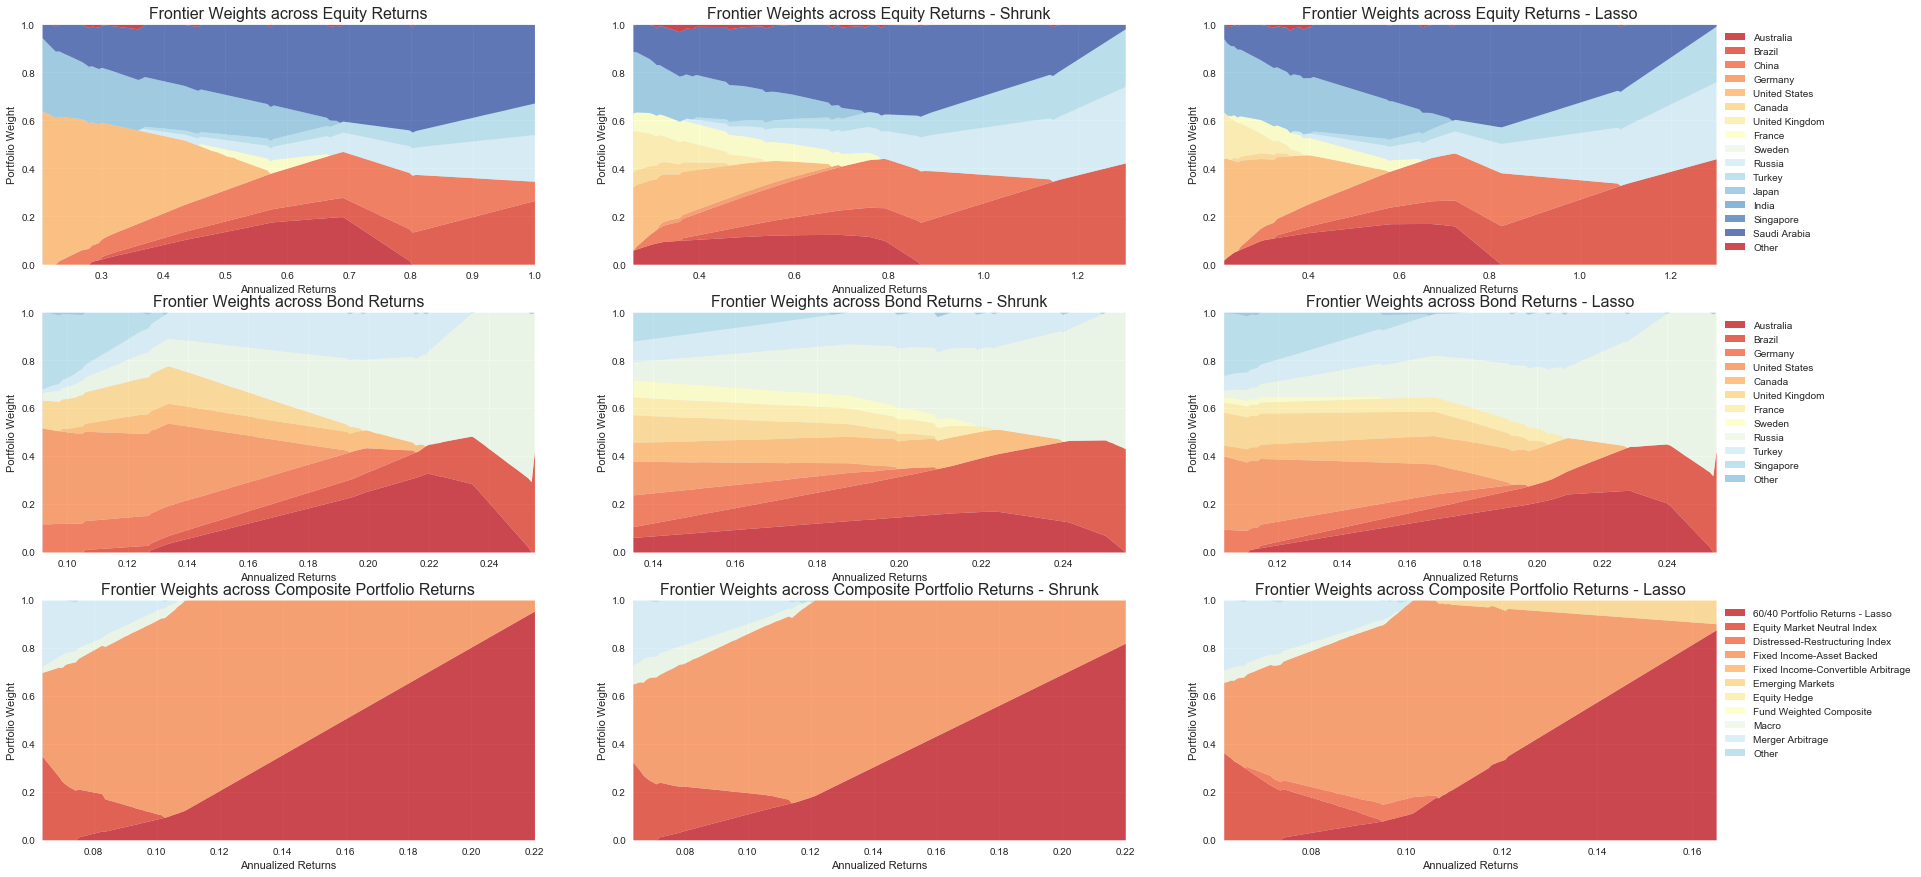

In [46]:
# Weight visualisation across target returns for the analysed portfolios

# Aggregation of the weigths dataframes using the function weight_df_builder(), in order to aggregate in one column
# the portfolio weights lower than 0.01 of the weights dataframe of the Mean variance Frontier. Different
# dataframes are built according to the different methodologies employed to estimate the covariance matrix of
# the Country Equity Indices
compact_optimal_shrunk_equity_frontier_weights_df = weight_df_builder(optimal_shrunk_equity_frontier_weights_df)
compact_optimal_lasso_equity_frontier_weights_df = weight_df_builder(optimal_lasso_equity_frontier_weights_df)

# Aggregation of the weigths dataframes using the function weight_df_builder(), in order to aggregate in one column
# the portfolio weights lower than 0.01 of the weights dataframe of the Mean variance Frontier. Different
# dataframes are built according to the different methodologies employed to estimate the covariance matrix of
# the Sovereign Bond Indices
compact_optimal_bond_frontier_weights_df = weight_df_builder(optimal_bond_frontier_weights_df)
compact_optimal_shrunk_bond_frontier_weights_df = weight_df_builder(optimal_shrunk_bond_frontier_weights_df)
compact_optimal_lasso_bond_frontier_weights_df = weight_df_builder(optimal_lasso_bond_frontier_weights_df)

# Aggregation of the weigths dataframes using the function weight_df_builder(), in order to aggregate in one column
# the portfolio weights lower than 0.01 of the weights dataframe of the Mean variance Frontier. Different
# dataframes are built according to the different methodologies employed to estimate the covariance matrix of
# the Hedge Fund Indices and 60-40 equity-bond portfolio
compact_optimal_sixty_forty_hf_frontier_weights_df = weight_df_builder(optimal_sixty_forty_hf_frontier_weights_df)
compact_optimal_shrunk_sixty_forty_hf_frontier_weights_df = \
    weight_df_builder(optimal_shrunk_sixty_forty_hf_frontier_weights_df)
compact_optimal_lasso_sixty_forty_hf_frontier_weights_df = \
    weight_df_builder(optimal_lasso_sixty_forty_hf_frontier_weights_df)

# We change the palette of color of the graph, such that we obtain 15 different colors gradation among red, yellow
# and blue
with seaborn.color_palette("RdYlBu", n_colors=15):

    # We create a empty figure and divide starting from the beginning the space in a matrix of empty graphs made of
    # three rows and three columns
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Country Equity indices and evaluated using the empirical covariance method
    compact_optimal_equity_frontier_weights_df.plot(ax=axes[0, 0], kind='area', lw=0, alpha=0.8, legend=False)
    # Setting the graph details
    axes[0, 0].set_title('Frontier Weights across Equity Returns', fontsize=16)
    axes[0, 0].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_equity_frontier_weights_df.index),
                         max(compact_optimal_equity_frontier_weights_df.index)])

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Country Equity indices and evaluated using the Shrunk covariance method
    compact_optimal_shrunk_equity_frontier_weights_df.plot(ax=axes[0, 1], kind='area', lw=0, alpha=0.8, legend=False)
    # Setting the graph details
    axes[0, 1].set_title('Frontier Weights across Equity Returns - Shrunk', fontsize=16)
    axes[0, 1].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_shrunk_equity_frontier_weights_df.index),
                         max(compact_optimal_shrunk_equity_frontier_weights_df.index)])

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Country Equity indices and evaluated using the Graphical Lasso covariance method
    compact_optimal_lasso_equity_frontier_weights_df.plot(ax=axes[0, 2], kind='area', lw=0, alpha=0.8, legend=False)
    # Setting the graph details
    axes[0, 2].set_title('Frontier Weights across Equity Returns - Lasso', fontsize=16)
    axes[0, 2].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_lasso_equity_frontier_weights_df.index),
                         max(compact_optimal_lasso_equity_frontier_weights_df.index)])
    # Displaying of the legend only on the third graph, outside the chart area, adjusted such that it does not overlap
    # with other figures
    axes[0, 2].legend(loc='upper left', prop={'size': 10}, bbox_to_anchor=(1, 1))

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Sovereign Bond indices and evaluated using the empirical covariance method
    compact_optimal_bond_frontier_weights_df.plot(ax=axes[1, 0], kind='area', lw=0, alpha=0.8, legend=False)
    # Setting the graph details
    axes[1, 0].set_title('Frontier Weights across Bond Returns', fontsize=16)
    axes[1, 0].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_bond_frontier_weights_df.index),
                         max(compact_optimal_bond_frontier_weights_df.index)])

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Sovereign Bond indices and evaluated using the Shrunk covariance method
    compact_optimal_shrunk_bond_frontier_weights_df.plot(ax=axes[1, 1], kind='area', lw=0, alpha=0.8, legend=False)
    # Setting the graph details
    axes[1, 1].set_title('Frontier Weights across Bond Returns - Shrunk', fontsize=16)
    axes[1, 1].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_shrunk_bond_frontier_weights_df.index),
                         max(compact_optimal_shrunk_bond_frontier_weights_df.index)])

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Sovereign Bond indices and evaluated using the Graphical Lasso covariance method
    compact_optimal_lasso_bond_frontier_weights_df.plot(ax=axes[1, 2], kind='area', lw=0, alpha=0.8, legend=False)
    # Setting the graph details
    axes[1, 2].set_title('Frontier Weights across Bond Returns - Lasso', fontsize=16)
    axes[1, 2].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_lasso_bond_frontier_weights_df.index),
                         max(compact_optimal_lasso_bond_frontier_weights_df.index)])
    # Displaying of the legend only on the third graph, outside the chart area, adjusted such that it does not overlap
    # with other figures
    axes[1, 2].legend(loc='upper left', prop={'size': 10}, bbox_to_anchor=(1, 1))

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Hedge Fund Indices and 60-40 equity-bond portfolio and evaluated using the empirical covariance method
    compact_optimal_sixty_forty_hf_frontier_weights_df.plot(ax=axes[2, 0], kind='area', lw=0, alpha=0.8, legend=False)
    axes[2, 0].set_title('Frontier Weights across Composite Portfolio Returns', fontsize=16)
    # Setting the graph details
    axes[2, 0].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_sixty_forty_hf_frontier_weights_df.index),
                         max(compact_optimal_sixty_forty_hf_frontier_weights_df.index)])

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Hedge Fund Indices and 60-40 equity-bond portfolio and evaluated using the Shrunk covariance method
    compact_optimal_shrunk_sixty_forty_hf_frontier_weights_df.plot(ax=axes[2, 1], kind='area', lw=0, alpha=0.8,
                                                                   legend=False)
    # Setting the graph details
    axes[2, 1].set_title('Frontier Weights across Composite Portfolio Returns - Shrunk', fontsize=16)
    axes[2, 1].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_shrunk_sixty_forty_hf_frontier_weights_df.index),
                         max(compact_optimal_shrunk_sixty_forty_hf_frontier_weights_df.index)])

    # Plotting of the area chart of the development of the mean variance frontier weights for the portfolio made of
    # Hedge Fund Indices and 60-40 equity-bond portfolio and evaluated using the Graphical Lasso covariance method
    compact_optimal_lasso_sixty_forty_hf_frontier_weights_df.plot(ax=axes[2, 2], kind='area', lw=0, alpha=0.8,
                                                                  legend=False)
    # Setting the graph details
    axes[2, 2].set_title('Frontier Weights across Composite Portfolio Returns - Lasso', fontsize=16)
    axes[2, 2].set(xlabel='Annualized Returns', ylabel='Portfolio Weight', ylim=[0, 1],
                   xlim=[min(compact_optimal_lasso_sixty_forty_hf_frontier_weights_df.index),
                         max(compact_optimal_lasso_sixty_forty_hf_frontier_weights_df.index)])
    # Displaying of the legend only on the third graph, outside the chart area, adjusted such that it does not overlap
    # with other figures
    axes[2, 2].legend(loc='upper left', prop={'size': 10}, bbox_to_anchor=(1, 1))
    fig.savefig('Frontier Weights Comparison - Different Covariance Methods.png', dpi=150)

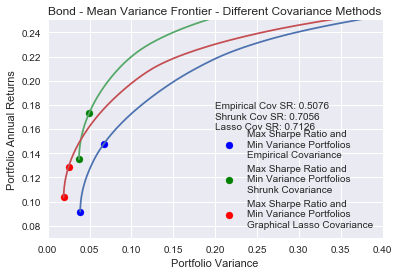

In [47]:
# Mean Variance Frontiers visualisation
# Calculation of the average risk free rate over the whole sample, in order to perform the calculation of the
# Sharpe Ratio
avg_ann_rf_rate = np.mean(annual_returns(monthly_rf_df))

# Sharpe Ratio calculation of the Country Equity Indices portfolio, formed using different covariance estimation
# methods
equity_SR = (optimal_equity_portfolio.iloc[1, 0] - avg_ann_rf_rate)/np.sqrt(optimal_equity_portfolio.iloc[1, 1])
shrunk_equity_SR = \
    (optimal_shrunk_equity_portfolio.iloc[1, 0] - avg_ann_rf_rate)/np.sqrt(optimal_shrunk_equity_portfolio.iloc[1, 1])
lasso_equity_SR = \
    (optimal_lasso_equity_portfolio.iloc[1, 0] - avg_ann_rf_rate)/np.sqrt(optimal_lasso_equity_portfolio.iloc[1, 1])

# Preparation of the string to be printed out in the following graphs, displaying the sharpe ratio of the portfolios
# calculated using different covariance methods
equity_sr_str = 'Empirical Cov SR: ' + str(round(float(equity_SR), 4)) +\
                '\nShrunk Cov SR: ' + str(round(float(shrunk_equity_SR), 4)) + \
                '\nLasso Cov SR: ' + str(round(float(lasso_equity_SR), 4))

# Definition of an empty figure where to plot the graphs
fig, ax = plt.subplots()

# Plotting of the mean-variance frontiers of the portfolios formed with Country Equity Indices, whose weights have been
# estimated with different covariance methods
ax.plot(optimal_equity_frontier_data.iloc[:, 0], optimal_equity_frontier_data.iloc[:, 1],
        optimal_shrunk_equity_frontier_data.iloc[:, 0], optimal_shrunk_equity_frontier_data.iloc[:, 1],
        optimal_lasso_equity_frontier_data.iloc[:, 0], optimal_lasso_equity_frontier_data.iloc[:, 1], label='')

# Scatter plots displaying the maxiumum sharpe ratio and minimum variance portfolio of the Country Equity indices
# portfolios formed using different covariance methods
ax.scatter(optimal_equity_portfolio.iloc[:, 1], optimal_equity_portfolio.iloc[:, 0], color='blue',
           label='Max Sharpe Ratio and \nMin Variance Portfolios\nEmpirical Covariance')
ax.scatter(optimal_shrunk_equity_portfolio.iloc[:, 1], optimal_shrunk_equity_portfolio.iloc[:, 0], color='green',
           label='Max Sharpe Ratio and \nMin Variance Portfolios\nShrunk Covariance ')
ax.scatter(optimal_lasso_equity_portfolio.iloc[:, 1], optimal_lasso_equity_portfolio.iloc[:, 0], color='red',
           label='Max Sharpe Ratio and \nMin Variance Portfolios\nGraphical Lasso Covariance')

ax.set(ylim=[0.15, 1], xlim=[0, 2.7], title='Equity - Mean Variance Frontier - Different Covariance Methods')
ax.set_xlabel('Portfolio Variance')
ax.set_ylabel('Portfolio Annual Returns')

# Printing on the graph the values of the shapre ratio of the portfolio formed
ax.text(0.1, 0.8, equity_sr_str)
ax.legend()
fig.savefig('Equity - Mean Variance Frontier Comparison')

# Sharpe Ratio calculation of the Sovereign Bond Indices portfolio, formed using different covariance estimation
# methods
bond_SR = (optimal_bond_portfolio.iloc[1, 0] - avg_ann_rf_rate)/np.sqrt(optimal_bond_portfolio.iloc[1, 1])
shrunk_bond_SR = (optimal_shrunk_bond_portfolio.iloc[1, 0] - avg_ann_rf_rate) / \
                 np.sqrt(optimal_shrunk_bond_portfolio.iloc[1, 1])
lasso_bond_SR = (optimal_lasso_bond_portfolio.iloc[1, 0] - avg_ann_rf_rate) / \
                np.sqrt(optimal_lasso_bond_portfolio.iloc[1, 1])

# Preparation of the string to be printed out in the following graphs, displaying the sharpe ratio of the portfolios
# calculated using different covariance methods
bond_sr_str = 'Empirical Cov SR: ' + str(round(float(bond_SR), 4)) + \
              '\nShrunk Cov SR: ' + str(round(float(shrunk_bond_SR), 4)) + \
              '\nLasso Cov SR: ' + str(round(float(lasso_bond_SR), 4))

# Definition of an empty figure where to plot the graphs
fig, ax = plt.subplots()

# Plotting of the mean-variance frontiers of the portfolios formed with Sovereign Bond Indices, whose weights have been
# estimated with different covariance methods
ax.plot(optimal_bond_frontier_data.iloc[:, 0], optimal_bond_frontier_data.iloc[:, 1],
        optimal_shrunk_bond_frontier_data.iloc[:, 0], optimal_shrunk_bond_frontier_data.iloc[:, 1],
        optimal_lasso_bond_frontier_data.iloc[:, 0], optimal_lasso_bond_frontier_data.iloc[:, 1], label='')

# Scatter plots displaying the maxiumum sharpe ratio and minimum variance portfolio of the Sovereign Bond Indices
# portfolios formed using different covariance methods
ax.scatter(optimal_bond_portfolio.iloc[:, 1], optimal_bond_portfolio.iloc[:, 0], color='blue',
           label='Max Sharpe Ratio and \nMin Variance Portfolios\nEmpirical Covariance')
ax.scatter(optimal_shrunk_bond_portfolio.iloc[:, 1], optimal_shrunk_bond_portfolio.iloc[:, 0], color='green',
           label='Max Sharpe Ratio and \nMin Variance Portfolios\nShrunk Covariance')
ax.scatter(optimal_lasso_bond_portfolio.iloc[:, 1], optimal_lasso_bond_portfolio.iloc[:, 0], color='red',
           label='Max Sharpe Ratio and \nMin Variance Portfolios\nGraphical Lasso Covariance')

# Setting up the graph details
ax.set(ylim=[0.07, 0.25], xlim=[0, 0.4], title='Bond - Mean Variance Frontier - Different Covariance Methods')
ax.set_xlabel('Portfolio Variance')
ax.set_ylabel('Portfolio Annual Returns')

# Printing on the graph the values of the shapre ratio of the portfolio formed
ax.text(0.20, 0.16, bond_sr_str)
ax.legend()
fig.savefig('Bond - Mean Variance Frontier Comparison')


# Sharpe Ratio calculation of the Hedge Fund Indices and 60-40 equity-bond portfolio, formed using different
# covariance estimation methods
sixty_forty_hf_SR = \
    (optimal_sixty_forty_hf_portfolio.iloc[1, 0] - avg_ann_rf_rate)/np.sqrt(optimal_sixty_forty_hf_portfolio.iloc[1, 1])

shrunk_sixty_forty_hf_SR = \
    (optimal_shrunk_sixty_forty_hf_portfolio.iloc[1, 0] - avg_ann_rf_rate) / \
    np.sqrt(optimal_shrunk_sixty_forty_hf_portfolio.iloc[1, 1])

lasso_sixty_forty_hf_SR = (optimal_lasso_sixty_forty_hf_portfolio.iloc[1, 0] - avg_ann_rf_rate) / \
                          np.sqrt(optimal_lasso_sixty_forty_hf_portfolio.iloc[1, 1])

# Preparation of the string to be printed out in the following graphs, displaying the sharpe ratio of the portfolios
# calculated using different covariance methods
sixty_forty_hf_sr_str = 'Empirical Cov SR: ' + str(round(float(sixty_forty_hf_SR), 4)) + \
                        '\nShrunk Cov SR: ' + str(round(float(shrunk_sixty_forty_hf_SR), 4)) + \
                        '\nLasso Cov SR: ' + str(round(float(lasso_sixty_forty_hf_SR), 4))

# Definition of an empty figure where to plot the graphs
fig, ax = plt.subplots()

# Plotting of the mean-variance frontiers of the portfolios formed with Hedge Fund Indices and 60-40 equity-bond
# portfolio, whose weights have been estimated with different covariance methods
ax.plot(optimal_sixty_forty_hf_frontier_data.iloc[:, 0], optimal_sixty_forty_hf_frontier_data.iloc[:, 1],
        optimal_shrunk_sixty_forty_hf_frontier_data.iloc[:, 0], optimal_shrunk_sixty_forty_hf_frontier_data.iloc[:, 1],
        optimal_lasso_sixty_forty_hf_frontier_data.iloc[:, 0], optimal_lasso_sixty_forty_hf_frontier_data.iloc[:, 1],
        label='')

# Scatter plots displaying the maxiumum sharpe ratio and minimum variance portfolio of the Hedge Fund Indices and 60-40
# equity-bond portfolios formed using different covariance methods
ax.scatter(optimal_sixty_forty_hf_portfolio.iloc[:, 1], optimal_sixty_forty_hf_portfolio.iloc[:, 0], color='blue',
           label='Max Sharpe Ratio and \nMin Variance Portfolios\nEmpirical Covariance')
ax.scatter(optimal_shrunk_sixty_forty_hf_portfolio.iloc[:, 1], optimal_shrunk_sixty_forty_hf_portfolio.iloc[:, 0],
           color='green', label='Max Sharpe Ratio and \nMin Variance Portfolios\nShrunk Covariance')
ax.scatter(optimal_lasso_sixty_forty_hf_portfolio.iloc[:, 1], optimal_lasso_sixty_forty_hf_portfolio.iloc[:, 0],
           color='red', label='Max Sharpe Ratio and \nMin Variance Portfolios\nGraphical Lasso Covariance')
ax.set(ylim=[0.03, 0.2], xlim=[0, 0.05],
       title='60/40 Bond-Equity and Hedge Fund \nMean Variance Frontier - Different Covariance Methods')
# Setting up the graph details
ax.set_xlabel('Portfolio Variance')
ax.set_ylabel('Portfolio Annual Returns')

# Printing on the graph the values of the shapre ratio of the portfolio formed
ax.text(0.025, 0.06, sixty_forty_hf_sr_str)
ax.legend()
fig.savefig('60-40 Bond-Equity and Hedge Fund - Mean Variance Frontier Comparison')

In [48]:
def return_predictor(asset_returns, global_factor_df, rf_rate, forecast_periods, expected_returns='FF3',
                     cov_method='empirical', title='Portfolio Predicted vs Realized and Decomposition.png'):
    """ This function calculates the pseudo-forecasts of a portfolio, given the return series of an asset universe, and
    the Fama French Factors that we want to use as independent variables to estimate the asset returns. The portfolio
    is optimally formed through the maximization of its sharpe ratio. The predicted returns are then plotted in a graph
    and compared with the observed returns. the RMSE is calculated as well as the sharpe ratio of the portfolio.
    Finally, the weights of the portfolio are displayed in a pie chart
    :param asset_returns: a dataframe of asset returns
    :param global_factor_df: the factors according to which we will ttry to predict our returns
    :param rf_rate: the risk free rate time series
    :param forecast_periods: the number of periods we would like to forecast. Our dataframe will be split in test and
    train according to this parameter
    :param expected_returns: Kind of expected returns we want to employ in the optimization process: FF3 for linear
    expected returns calculated using the Fama French regression model; ANN if we want to calculate them employing an
    artificial neural network method, where the shape of the hidden layers is automatically tuned in the system.
    :param cov_method: covariance to employ in the optimization: 'empirical' for empirical covariance, 'lasso' for
    graphical lasso covariance
    :param title: name of the output filename. It is going to be a graph
    :return: a graph depicting the forecasted returns of a portfolio, compared with the observed portfolio returns, and
    displaying the RMSE of the forecasts. Moreover a second graph is depicted, showing the weight allocation of the
    portfolio
    """
    # We define the length of the time series of our asset returns. Useful later, to make sure that all the other
    # time series utilized have the same length
    asset_history = len(asset_returns)

    # Harmonization on the length of the factor dataframe with the length of the returns dataframe
    global_factor_df = global_factor_df.iloc[-asset_history:, :]

    # Harmonization on the length of the risk free rate time series with the length of the returns dataframe
    rf_rate = rf_rate.iloc[-asset_history:]

    # Definition of the market excess returns as R_m - rf, taking the market returns from the global_factor_df
    market_excess_returns = global_factor_df.iloc[:, 0].subtract(rf_rate, axis=0)

    # Concatenation that aims at forming the factors dataframe with the market excess returns rather than with only the
    # market return. This is done in accordance with theh sharpe ratio mximization process from Topin 1964
    # The dataframe is alse slicedin order to define the training set of our model accordingly with the forecast periods
    # chosen by the user
    global_factor_train = \
        pd.concat([market_excess_returns, global_factor_df.iloc[:, 1:]], axis=1).iloc[:-forecast_periods, :]

    # Riclassification of the columns of the factor training dataframe
    global_factor_train.columns = ['Market Excess Returns', 'SMB', 'HML']

    # Concatenation that aims at forming the factors dataframe with the market excess returns rather than with only the
    # market return. This is done in accordance with the sharpe ratio mximization process from Tobin 1964
    # The dataframe is alse sliced in order to define the test set of our model accordingly with the forecast periods
    # chosen by the user
    global_factor_test = \
        pd.concat([market_excess_returns, global_factor_df.iloc[:, 1:]], axis=1).iloc[-forecast_periods:, :]

    # Reclassification of the columns of the factor test dataframe
    global_factor_test.columns = ['Market Excess Returns', 'SMB', 'HML']

    # Definition of the asset excess returns as R_i - rf and slicing of the returns time series in order to define the
    # training set of our model accordingly with the forecast periods chosen by the user
    asset_train = asset_returns.subtract(rf_rate, axis=0).iloc[:-forecast_periods, :]

    # Definition of the asset excess returns as R_i - rf and slicing of the returns time series in order to define the
    # test set of our model accordingly with the forecast periods chosen by the user
    asset_test = asset_returns.subtract(rf_rate, axis=0).iloc[-forecast_periods:, :]

    # Conditional on the setting specified by the user, the function will calculate the expected return of the test set
    # using the Fama French linear model, or the Artificial Neural Network
    if expected_returns == 'FF3':

        # Estimating a regression model using the training set of Fama French Factors as independent variables and the
        # training set of asset returns as dependent variables, and storing its results in the variable fitted_model
        fitted_model = sm.OLS(asset_train, sm.add_constant(global_factor_train)).fit()

        # Calculation of the predicted returns using the calculated coefficients of the regression of the training on
        # the Fama french Factors of the test set
        predicted_returns = pd.DataFrame(fitted_model.predict(sm.add_constant(global_factor_test)))

        # Assigning the name of the columns to the newly calculated predicted returns
        predicted_returns.columns = asset_train.columns

    elif expected_returns == 'ANN':

        # Definition of a variable that contains a set of tuples which are going to represent the possible hidden
        # layer structure of the Artificial Neural Network implemented later. The variable is used for the tuning of
        # the model
        hidden_layers = [x for x in itertools.product(np.arange(5, 11), repeat=3)]

        # Dictionary that takes as keyword the parameter name 'hidden_layer_sizes' of the object MLPRegressor, and as
        # values the list of tuples of possible hidden layer structures. The dictionary is used to tune the
        # hidden_layer_sizes parameter of our Artificial Neural Network model
        parameters = {'hidden_layer_sizes': hidden_layers}

        # Definition of the ANN object to be tuned. The fixed parameters have been chosen in accordance with the
        # peculiarities of our data
        model = MLPRegressor(alpha=0.0001, activation='identity', learning_rate='constant', max_iter=1000,
                             solver='lbfgs')

        # Definition of the GridSearchCV object. It takes as parameters the model that we want to tune, and the
        # parameters, defined in a dictionary, among which we want to find the best value. In this case we are going
        # to seacrh which structure gives us the best performing ANN model
        grid_search = GridSearchCV(model, parameters)

        # Fitting of the GridSearchCV object define above. The fucntion is going to find the best hidden layer structure
        # among the ones specified in the parameters dictionary
        grid_search.fit(global_factor_train, asset_train)

        # Definition of the new model using the same parameters specified before, and the tuned parameter resulting
        # from the GridSearchCV findings
        model = MLPRegressor(alpha=0.0001, hidden_layer_sizes=grid_search.best_estimator_.hidden_layer_sizes,
                             activation='identity', learning_rate='constant', max_iter=1000, solver='lbfgs')

        # We fit our new model with the training set of the Fama French Factors in order to find the wet of
        # optimal weights that best predict the training set of the asset returns
        model.fit(global_factor_train, asset_train)

        # According to the weights of the ANN model, we predict the asset returns using the test set of the Fama French
        # Factors and we store the results in a dataframe
        predicted_returns = pd.DataFrame(model.predict(global_factor_test), columns=asset_returns.columns,
                                         index=asset_test.index)

    # According to the covariance method chosen in the inputs, we calculate launch the function optimal_portfolio()
    # using as input the covariance type: 'empirical' or 'lasso', overriding the expected returns with the mean of the
    # previously calculated predicted returns
    if cov_method == 'empirical':
        weights, portfolio = optimal_portfolio(asset_returns, rf_rate, expected_returns=np.mean(predicted_returns))
    elif cov_method == 'lasso':
        weights, portfolio = \
            optimal_portfolio(asset_returns, rf_rate, covMethod='lasso', expected_returns=np.mean(predicted_returns))

    # Calculation of the predicted portfolio returns of the maximum sharpe ratio portfolio, using the weights from
    # the optimal_portfolio() function
    predicted_portfolio_returns = pd.DataFrame(np.matmul(predicted_returns, weights['Efficient Weights']),
                                               columns=['Predicted Returns'], index=asset_test.index)

    # Calculation of the realized portfolio returns of the maximum sharpe ratio portfolio, using the weights from
    # the optimal_portfolio() function
    realized_portfolio_returns = pd.DataFrame(np.matmul(asset_test, weights['Efficient Weights']),
                                              columns=['Realized Returns'], index=asset_test.index)

    # Creation of a dataframe which contains the values of the predicted and realized returns of the optimal
    # portfolio estimated with the optimal_portfolio() function
    portfolio_return_comparison = pd.concat([predicted_portfolio_returns, realized_portfolio_returns], axis=1)

    # Calculation of the Root Mean Squares Errors between the predicted and the realized portfolio returns
    RMSE = round(np.sqrt(metrics.mean_squared_error(realized_portfolio_returns, predicted_portfolio_returns)), 4)

    # Calculation of the Sharpe Ratio of the maximum sharpe ratio portfolio
    pf_sr = (portfolio.iloc[1, 0] - np.mean(annual_returns(rf_rate)))/ np.sqrt(portfolio.iloc[1, 1])

    # Creation of a string which makes the information about the sharpe ratio ready to be printed
    pf_sr_str = 'Portfolio Sharpe Ratio: ' + str(round(float(pf_sr), 4))

    # Aggregation of the weights dataframe. This function substitutes vweight values lower than 0.01 with zero, and
    # aggregates them in a column called Other
    weights_aggregated = weight_df_builder(weights.T).loc['Efficient Weights']

    # We exclude from the weights dataframe the rows, whose value is zero
    weights_aggregated = weights_aggregated[weights_aggregated.loc[:] > 0]

    # Start of the plotting session: we define a figure with 2 subplots in one column
    fig, ax = plt.subplots(figsize=(10, 15))

    # Definition of the first subplot
    ax = plt.subplot(2, 1, 1)

    # Plotting of the realized vs. predicted returns
    portfolio_return_comparison.plot(ax=ax)
    ax.set_ylim([-0.07, 0.1])
    ax.set_xlim(asset_test.index[0], asset_test.index[-1])
    ax.set_ylabel('Portfolio Returns')
    ax.set_title('Portfolio Performances')

    # Print on the plot area the information about the Root Mean Squares Error and Sharpe ratio calculated before
    ax.text(asset_test.index[1], 0.07, 'RMSE = ' + str(RMSE) + '\n' + pf_sr_str)

    # Changing the colors of the sections of the pie chart to make them more distinguishable
    with seaborn.color_palette(palette='Paired', n_colors=10):

        # Definition of the second subplot
        ax1 = plt.subplot(2, 1, 2)

        # Designing a pie chart whose labels are the columns of the weights dataframe, and the values are expressed in
        # percentage points
        weights_aggregated[weights_aggregated.loc[:] > 0].plot(ax=ax1, kind='pie', autopct='%1.1f%%',
                                                               labels=weights_aggregated.index)

        # Setting the graphs details
        ax1.set_title('Weights Decomposition of the\nMax Sharpe Ratio Portfolio')
        ax1.set_ylabel('')

        # We make sure that the pie chart has an circular rather than elliptical
        ax1.axis('equal')

        # Positioning the legend of the pie chart so that it does not overlap with other text in the figure
        ax1.legend(loc='upper left', prop={'size': 8}, bbox_to_anchor=(-0.1, 1.1))

    # Saving the figure with the file name specified in the inputs of the fucntion
    fig.savefig(title, dpi=150)

    # This function returns no output
    return None

In [49]:
# Setting the forecasts periods to be set in the following functions
forecast_periods = 24

# Start of the Graphical analysis of the portfolio predictions using a linear factor model and the empirical covariance
# vs. a Artificial Neural Network model and a Graphical Lasso covariance. The forecasts results are plotted in a graph
# and information about the Root Mean Squared Error and the Sharpe Ratio of the portfolio are displayed. Moreover
# the weight allocation of the portfolios are showed in a pie chart. This is done for all the portfolios analysed so far
return_predictor(monthly_Eq_Ret, FF3Factors_df, monthly_rf_df, forecast_periods,
                 title='Equity - Fama French Pred Returns Performace and Weight Decomposition.png')

return_predictor(monthly_Eq_Ret, FF3Factors_df, monthly_rf_df, forecast_periods,
                 title='Equity - ANN Pred Returns Performace and Weight Decomposition.png', expected_returns='ANN',
                 cov_method='lasso')

return_predictor(monthly_bond_ret, FF3Factors_df, monthly_rf_df, forecast_periods,
                 title='Bond - Fama French Pred Returns Performace and Weight Decomposition.png')

return_predictor(monthly_bond_ret, FF3Factors_df, monthly_rf_df, forecast_periods,
                 title='Bond - ANN Pred Returns Performace and Weight Decomposition.png', expected_returns='ANN',
                 cov_method='lasso')

return_predictor(sixty_forty_hf_portfolio_ret, FF3Factors_df, monthly_rf_df, forecast_periods,
                 title='Composite Portfolio - Fama French Pred Returns Performace and Weight Decomposition.png')

return_predictor(sixty_forty_hf_portfolio_ret, FF3Factors_df, monthly_rf_df, forecast_periods,
                 title='Composite Portfolio - ANN Pred Returns Performace and Weight Decomposition.png',
                 expected_returns='ANN', cov_method='lasso')

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\Chris\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
